<a href="https://colab.research.google.com/github/leehimcm/AI-SS-ASSISTANT-AI/blob/main/ppo_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ppo_v5
* 반복 실험 코드 수정
* 성능 향상
* 온보딩 데이터 반영

### 구글 드라이브 마운트 (필요 시 사용)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # 작업 디렉토리 변경
# import os
# print(os.getcwd(), end=' -> ')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/25-capstone')
# print(os.getcwd())

### 라이브러리 설치

In [2]:
!pip install pulp gymnasium==0.28.1 tianshou==1.2.0 numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pettingzoo to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.1/273.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 33.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installa

### import

In [1]:
import random
import numpy as np
from datetime import date, datetime, timedelta, time
from typing import List, Dict, Optional, Tuple
from collections import defaultdict, deque
import pulp

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import gymnasium as gym
from gymnasium import spaces

import tianshou as ts
from tianshou.env import DummyVectorEnv
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import Actor, Critic
from tianshou.policy import PPOPolicy
from tianshou.data import Collector
from torch.distributions import Categorical, Distribution

from tianshou.utils.logger.tensorboard import TensorboardLogger
from tianshou.trainer import OnpolicyTrainer

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 내부 데이터
* user_info: 온보딩 데이터
*   cleaning_tasks: 청소 관련 정보 포함됨, 수정되지 않는 데이터
*   user_cleaning_status: 각 청소의 마지막 수행 일자 (앱에서 받아 온 청소 완료 기록 데이터 기반으로 수정됨)
* user_execution_data: 과거 청소 기록 데이터




In [43]:
user_info = {
  "user_nickname": "김청소",
  "user_address": "서울특별시 서대문구 대신동",
  "survey_responses": {
    "cleaning_frequency": "매일 (주 7회)",
    "cleaning_distribution": "나눠서 조금씩 꾸준히",
    "preferred_time_range": "06:00-12:00",
    "preferred_days": ["월요일", "수요일", "금요일"],
    "item_quantity": "물건이 적어서 정리가 쉬워요"
  }
}


In [44]:
user_info = {
  "user_nickname": "김청소",
  "user_address": "서울특별시 서대문구 대신동",
  "survey_responses": {
    "cleaning_frequency": 1, # 주 n일 청소 -> n/7
    "cleaning_distribution": (1.0, 0.0), # (consistency, intensity) 나눠서 꾸준히 (1.0, 0.0), 혼합형 (0.5, 0.5), 몰아서 한 번에 (0.0, 1.0)
    "preferred_time_range": (6, 12),
    "preferred_days": [0, 2, 4],
    "item_quantity": 0.3 # 0-0.3 적음 / 0.3-0.6 보통 / 0.6-1.0 많음
  }
}


In [45]:
# cleaning_tasks: 청소 관련 정보 포함됨, 수정되지 않는 데이터
cleaning_tasks = [
    {"주방 - 수건 교체": {"duration": 5 / 60, "interval": 5, "description": "깨끗한 수건으로 교체 후 사용한 수건은 세탁 바구니에 넣기"}},
    {"주방 - 행주 삶기": {"duration": 10 / 60, "interval": 7, "description": "행주를 삶거나 세탁기에 고온세탁하여 위생 관리"}},
    {"주방 - 배기후드 기름떼 제거": {"duration": 20 / 60, "interval": 30, "description": "기름 제거제를 뿌리고 문질러 닦은 후 물로 헹구기"}},
    {"주방 - 냉장고 유통기한 지난 음식 1개 이상 처분": {"duration": 10 / 60, "interval": 7, "description": "유통기한 지난 식품 확인 후 폐기"}},

    {"세탁실 - 세탁기 세제통 씻기": {"duration": 10 / 60, "interval": 30, "description": "세제 찌꺼기를 제거하고 물로 헹군 후 건조"}},

    {"화장실 - 바닥 청소": {"duration": 10 / 60, "interval": 14, "description": "바닥에 락스를 뿌리고 청소솔과 세제로 구석구석 닦기"}},
    {"화장실 - 변기 청소": {"duration": 10 / 60, "interval": 7, "description": "변기 전용 세제로 내부와 테두리 문지르기"}},
    {"화장실 - 세면대 청소": {"duration": 7 / 60, "interval": 5, "description": "물때와 치약 자국 등을 세정제로 제거"}},
    {"화장실 - 하수구 청소": {"duration": 10 / 60, "interval": 7, "description": "막힘 방지용 세정제 또는 끓는 물로 청소"}},
    {"화장실 - 거울 닦기": {"duration": 5 / 60, "interval": 7, "description": "유리세정제로 물자국 닦기"}},
    {"화장실 - 수납장 내부 정리 및 청소": {"duration": 15 / 60, "interval": 90, "description": "모든 물건 꺼내고 내부를 닦은 후 재정리"}},

    {"거실 - 가구 표면 먼지 닦기 (물걸레)": {"duration": 5 / 60, "interval": 14, "description": "물에 적신 걸레로 가구 표면 닦기"}},
    {"거실 - 가구 표면 먼지 털기 (먼지털이)": {"duration": 5 / 60, "interval": 7, "description": "먼지털이개로 가볍게 먼지를 털어냄"}},
    {"거실 - 바닥 물걸레질": {"duration": 15 / 60, "interval": 3, "description": "청소기로 먼지 제거 후 물걸레질"}},
    {"거실 - 청소기로 바닥 먼지 제거": {"duration": 10 / 60, "interval": 2, "description": "진공청소기로 바닥과 카펫 먼지 제거"}},
    {"거실 - 테이블 위 정리": {"duration": 5 / 60, "interval": 2, "description": "불필요한 물건 정리 및 정돈"}},
    {"거실 - 안 쓰는 물건 1개 이상 처분": {"duration": 7 / 60, "interval": 10, "description": "수납공간 내 불필요한 물건 정리 및 기부/폐기"}},

    {"창틀 먼지 닦기": {"duration": 10 / 60, "interval": 14, "description": "젖은 걸레나 진공청소기를 이용해 틈새 먼지 제거"}},
    {"전자기기 소독": {"duration": 5 / 60, "interval": 5, "description": "알콜스왑이나 알콜티슈로 스마트폰, 컴퓨터 등 표면 닦기"}},
    {"쓰레기 배출": {"duration": 10 / 60, "interval": 3, "description": "생활 쓰레기 및 분리수거된 품목을 지정 장소에 배출"}},
    {"음식물 쓰레기 배출": {"duration": 5 / 60, "interval": 3, "description": "음식물 쓰레기를 지정 장소에 배출"}},
]

# user_cleaning_status: 사용자 청소 기록 데이터 (앱에서 받아 온 청소 완료 기록 데이터 기반으로 수정됨)
# last_done_days_ago: cleaning_tasks의 interval + 3 값으로
user_cleaning_status = {
    "주방 - 수건 교체": {"last_done_days_ago": 8},
    "주방 - 행주 삶기": {"last_done_days_ago": 10},
    "주방 - 배기후드 기름떼 제거": {"last_done_days_ago": 33},
    "주방 - 냉장고 유통기한 지난 음식 1개 이상 처분": {"last_done_days_ago": 10},

    "세탁실 - 세탁기 세제통 씻기": {"last_done_days_ago": 33},

    "화장실 - 바닥 청소": {"last_done_days_ago": 17},
    "화장실 - 변기 청소": {"last_done_days_ago": 10},
    "화장실 - 세면대 청소": {"last_done_days_ago": 8},
    "화장실 - 하수구 청소": {"last_done_days_ago": 10},
    "화장실 - 거울 닦기": {"last_done_days_ago": 10},
    "화장실 - 수납장 내부 정리 및 청소": {"last_done_days_ago": 93},

    "거실 - 가구 표면 먼지 닦기 (물걸레)": {"last_done_days_ago": 17},
    "거실 - 가구 표면 먼지 털기 (먼지털이)": {"last_done_days_ago": 10},
    "거실 - 바닥 물걸레질": {"last_done_days_ago": 6},
    "거실 - 청소기로 바닥 먼지 제거": {"last_done_days_ago": 5},
    "거실 - 테이블 위 정리": {"last_done_days_ago": 5},
    "거실 - 안 쓰는 물건 1개 이상 처분": {"last_done_days_ago": 13},

    "창틀 먼지 닦기": {"last_done_days_ago": 17},
    "전자기기 소독": {"last_done_days_ago": 8},
    "쓰레기 배출": {"last_done_days_ago": 7},
    "음식물 쓰레기 배출": {"last_done_days_ago": 6}
}



In [46]:
user_execution_data = {}
'''
{
   week: [...],
   ...
}
'''

'\n{\n   week: [...],\n   ...\n} \n'

### Integer Linear Programing 적용에 필요한 함수
* preprocessing_schedules()
* generate_initial_schedule()

In [6]:
# 사용자 일정(구글 캘린더, 수면) 전처리 함수
def preprocessing_schedules(week_start, week_end, raw_schedules):
    fixed_schedules = []
    for item in raw_schedules:
        start_dt = item['start']['dateTime']
        end_dt = item['end']['dateTime']

        # +09:00 제거
        start_dt = datetime.fromisoformat(start_dt[:-6])
        end_dt = datetime.fromisoformat(end_dt[:-6])

        # 여러 날에 걸친 일정을 하루 단위로 분리
        current = start_dt
        while current.date() <= end_dt.date():
            day_start = current.replace(hour=0, minute=0, second=0, microsecond=0)
            day_end = day_start + timedelta(days=1)

            seg_start = max(start_dt, day_start)
            seg_end = min(end_dt, day_end)

            if not (week_start <= seg_start.date() < week_end): # 이번주 데이터가 아닌 부분은 버린다
                current = day_end
                continue

            weekday = seg_start.weekday() # 요일 0=월, 6=일
            start_hour = seg_start.hour + seg_start.minute / 60
            end_hour = seg_end.hour + seg_end.minute / 60

            fixed_schedules.append({
                'summary': item['summary'],
                'location': item['location'],
                'day': weekday,
                'start': start_hour,
                'end': end_hour
            })

            current = day_end # 다음 날짜

    return fixed_schedules

In [7]:
def generate_initial_schedule(cleaning_tasks, user_cleaning_status, fixed_schedules,
                              total_cleaning_task_limit=10, total_cleaning_time_limit=5):
    # 1) ILP 문제 정의
    prob = pulp.LpProblem("CleaningScheduler", pulp.LpMaximize)

    # 2) 변수: 각 청소를 x요일 x시에 할지 말지 정함
    variables = {}
    for i, task in enumerate(cleaning_tasks):
        for d in range(7):  # 0 ~ 6(월요일~일요일)
            for h in range(24):  # 청소 시작시간
                variables[(i, d, h)] = pulp.LpVariable(f'task_{i}_day{d}_hour{h}', 0, 1, cat='Binary')

    # 3) 목적 함수 : 'interval', 'last_done_days_ago' 만족 -> 우선순위가 높은(미룬지 오래된) 청소 작업을 더 많이 포함
    objective = pulp.lpSum(
        (
            (
                (user_cleaning_status[task_name]["last_done_days_ago"] - task['interval'])
                + (7.0 if task['interval'] <= 3 else 0.0)
            ) / task['interval'] * variables[(i, d, h)]
        )
        for i, task_dict in enumerate(cleaning_tasks)
        for task_name, task in task_dict.items()
        for d in range(7) for h in range(24)
    )
    prob += objective

    # 4) 제약 조건
    # 제약 조건 안에서 최대한 많은 청소를 배정
    prob += pulp.lpSum([
        variables[(i, d, h)]
        for i in range(len(cleaning_tasks))
        for d in range(7) for h in range(24)])

    # 총 청소 개수 제한
    prob += pulp.lpSum([
        variables[(i, d, h)]
        for i in range(len(cleaning_tasks))
        for d in range(7) for h in range(24)]) <= total_cleaning_task_limit

    # 총 청소 시간 제한
    prob += pulp.lpSum([
        variables[(i, d, h)] * task['duration']
        for i, task_dict in enumerate(cleaning_tasks)
        for task_name, task in task_dict.items()
        for d in range(7) for h in range(24)]) <= total_cleaning_time_limit

    # 고정 일정 제외한 시간에만 청소 배정
    for i, task_dict in enumerate(cleaning_tasks):
        for task_name, task in task_dict.items():
            duration = task["duration"]
            for d in range(7):
                for h in range(24):
                    for sched in fixed_schedules:
                        if sched['day'] == d:
                            if sched['start'] < h + duration and sched['end'] > h:
                                prob += variables[(i, d, h)] == 0

    # 같은 시간대(x시:00분)에 실행되는 청소의 duration 합 <= 1시간
    for d in range(7):
        for h in range(24):
            prob += pulp.lpSum([
                variables[(i, d, h)] * task["duration"]
                for i, task_dict in enumerate(cleaning_tasks)
                for task in task_dict.values()
            ]) <= 1

    # 각 청소작업은 1주일에 (7 // interval)회 이하만 추천
    for i, task_dict in enumerate(cleaning_tasks):
        for task_name, task in task_dict.items():
            max_assign = max(1, 7 // task["interval"])
            prob += pulp.lpSum([
                variables[(i, d, h)]
                for d in range(7) for h in range(24)
            ]) <= max_assign

    # 최적화 수행
    prob.solve()

    # 결과 추출
    cleaning_schedules = []
    for i, task_dict in enumerate(cleaning_tasks):
        for task_name, task in task_dict.items():
            for d in range(7):
                for h in range(24):
                    if pulp.value(variables[(i, d, h)]) == 1:
                        cleaning_schedules.append([
                            task_dict, d, h
                        ])

    cleaning_schedules.sort(key=lambda x: (x[1], x[2])) # 요일, 시간 정렬
    return cleaning_schedules

### 직전 주차 데이터 처리에 필요한 함수
* compute_user_cleaning_status()
* compute_user_behavior()
* prev_execution()

In [8]:
# user_cleaning_status의 'last_done_days_ago' 업데이트
def compute_user_cleaning_status(prev_week_execution):
    global user_cleaning_status

    not_done = set(list(user_cleaning_status.keys())) # 최종적으로 안 한 청소만 남기기 위함
    for entry in prev_week_execution:
        if not entry['performed']:
            continue
        task = entry['task']
        prev_days_ago = user_cleaning_status[task]['last_done_days_ago']
        new_days_ago = 7 - entry['day'] # 며칠 전에 했는지 계산
        if new_days_ago < prev_days_ago: # 1주 동안 같은 task를 여러번 수행했을 경우 가장 최신 정보를 반영함
            user_cleaning_status[task]['last_done_days_ago'] = new_days_ago
        not_done.discard(task) # 수행한 청소는 삭제

    for task in not_done:
        user_cleaning_status[task]['last_done_days_ago'] += 7 # 이번주에 안 한 청소는 'last_done_days_ago' 7일 증가


In [9]:
# 시간 슬롯 당 청소 확률 벡터 계산(behavior vector)
def compute_user_behavior(prev_week_execution, prev_behavior=None, alpha=0.5):
    '''
    Parameters:
    - prev_week_execution: 지난주 청소 기록
    - prev_behavior: shape=(168,), 누적된 행동 벡터
    - alpha: 이전 행동 벡터 반영 비율

    Returns:
    - behavior_vector: shape=(168,), np.float32
    '''
    vector = np.zeros(168)
    for entry in prev_week_execution:
        index = entry['day'] * 24 + entry['hour'] # 168개 중 하나의 인덱스로 계산
        if entry['performed']:
            vector[index] += 1.0

    if vector.sum() > 0:
        vector /= vector.sum()
    vector = vector.astype(np.float32)  # 0.0 ~ 1.0 사이로 정규화 한 값 저장

    if prev_behavior is None:
        return vector
    else:
        # EWMA 업데이트
        return alpha * prev_behavior + (1 - alpha) * vector

In [10]:
# 직전 주의 청소 완료 기록 데이터만 추출
def prev_execution(user_execution_data, this_week=2):
    return user_execution_data.get(this_week-1, [])

### 필요한 wrapper, 함수
* MultiCategorical
* multi_categorical_dist_fn()
* build_slot_penalty_all_weeks()

In [11]:
class MultiCategorical(Distribution):
    arg_constraints = {}
    has_rsample = False

    def __init__(self, logits_list):
        # logits_list: List[Tensor] 각 텐서는 (B, n_i) 모양
        self.categoricals = [Categorical(logits=logits) for logits in logits_list]
        # batch_shape: e.g., torch.Size([B])
        batch_shape = self.categoricals[0].batch_shape
        event_shape = torch.Size([len(self.categoricals)])  # K branches
        super().__init__(batch_shape=batch_shape, event_shape=event_shape, validate_args=False)

    def sample(self):
        # (B, K) 정수 텐서
        return torch.stack([cat.sample() for cat in self.categoricals], dim=-1)

    def log_prob(self, actions):
        actions = actions.long()
        return torch.stack(
            [cat.log_prob(actions[..., i]) for i, cat in enumerate(self.categoricals)],
            dim=-1
        ).sum(dim=-1)


    def entropy(self):
        return torch.stack([cat.entropy() for cat in self.categoricals], dim=-1).sum(dim=-1)

    @property
    def mode(self):
        # (B, K) argmax
        return torch.stack([cat.probs.argmax(dim=-1) for cat in self.categoricals], dim=-1)

    @property
    def variance(self): # branch별 분산 계산
        vars_ = []
        for cat in self.categoricals:
            p = cat.probs
            mean = (torch.arange(p.shape[-1], device=p.device) * p).sum(dim=-1)
            var = ((torch.arange(p.shape[-1], device=p.device) - mean.unsqueeze(-1)) ** 2 * p).sum(dim=-1)
            vars_.append(var)
        return torch.stack(vars_, dim=-1)

    @property
    def stddev(self):
        return self.variance.sqrt()

    @property
    def probs(self): # 선택사항: 정책 로깅/디버깅에 유용
        return [cat.probs for cat in self.categoricals]


In [12]:
def multi_categorical_dist_fn(nvec):
    nvec = list(map(int, nvec))  # ensure list[int]
    def dist_fn(logits): # logits shape: (B, sum(nvec))
        # K개로 분리
        chunks = torch.split(logits, nvec, dim=-1)
        return MultiCategorical(chunks) # 단일 분포 객체로 감싸서 반환
    return dist_fn

In [13]:
from collections import OrderedDict

def build_slot_penalty_all_weeks(user_execution_data: dict, decay: float = 0.9) -> np.ndarray:
    slot_penalty = np.zeros(168, dtype=float)
    if not user_execution_data:
        return slot_penalty

    weeks_sorted = sorted(user_execution_data.keys())
    weight_by_week = {}
    last_week = weeks_sorted[-1]
    for w in weeks_sorted:
        weight_by_week[w] = decay ** (last_week - w)

    for w in weeks_sorted:
        weight = weight_by_week[w]
        for entry in user_execution_data[w]:
            if entry.get("performed"):
                idx = int(entry["day"] * 24 + entry["hour"])
                slot_penalty[idx] += 0.25 * weight

    np.clip(slot_penalty, 0.0, 1.0, out=slot_penalty)
    return slot_penalty


### 환경

In [37]:
class CleaningEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        fixed_schedules,
        cleaning_tasks,
        user_cleaning_status,
        user_behavior,
        user_execution_data,
        user_pref,
        initial_schedules=None,
    ):
        super().__init__()

        # ----- 입력 데이터 -----
        self.fixed_schedules = fixed_schedules
        self.cleaning_tasks = cleaning_tasks
        self.user_cleaning_status = user_cleaning_status
        self.behavior_vector = np.asarray(user_behavior, dtype=np.float32)
        self.user_execution_data = user_execution_data
        self.initial_schedules = initial_schedules or []
        self.survey_responses = user_pref

        # ----- 태스크 매핑 (빠른 조회) -----
        self.task_id2name = []
        self.task_name2meta = {}
        for i, d in enumerate(self.cleaning_tasks):
            name = list(d.keys())[0]
            self.task_id2name.append(name)
            self.task_name2meta[name] = d[name]

        # ----- 기본 설정 -----
        self.n_tasks = len(self.cleaning_tasks)
        self.current_step = 0
        self.max_steps = 32

        # action: (task_idx, day, hour)
        self.action_space = spaces.MultiDiscrete([self.n_tasks, 7, 24])

        # observation: 168 슬롯 x (fixed_vector: 고정일정, urgency_vector: 급함도, behavior_vector: 선호도)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(168 * 3,), dtype=np.float32)

        # ----- 런타임 상태 -----
        self.state = None                   # (504,)
        self.weekly_todo = []               # 최종 결과: [[{task_meta}, day, hour], ...]
        self.used_slots = set()             # (day, hour) 중복 방지

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed); random.seed(seed)
        super().reset(seed=seed)

        self.current_step = 0
        self.weekly_todo = []
        self.used_slots = set()
        self.state = self._get_initial_state()

        if self.user_execution_data:
            penalties = build_slot_penalty_all_weeks(self.user_execution_data, decay=0.9)
            self.state[168:168+168] = np.maximum(0.0, self.state[168:336] - penalties)

        return self.state.copy().astype(np.float32), {}

    def _get_initial_state(self):
        fixed_vector = np.zeros(168, dtype=np.float32)
        urgency_vector = np.zeros(168, dtype=np.float32)

        # 1) 고정 일정 마스킹
        for sched in self.fixed_schedules:
            start = int(sched['day'] * 24 + sched['start'])
            end = int(sched['day'] * 24 + sched['end'])
            start = max(0, min(167, start))
            end = max(0, min(168, end))
            if end > start:
                fixed_vector[start:end] = 1.0

        # 2) 급함도(urgency) 초기화: 각 task의 (last_done_days_ago / interval)을 168 슬롯에 균등 분산
        for d in self.cleaning_tasks:
            name = list(d.keys())[0]
            meta = d[name]
            interval = float(meta.get('interval', 7) or 0)  # None 방지
            last_done = float(self.user_cleaning_status.get(name, {}).get('last_done_days_ago', 0.0))
            if interval <= 0:
                urgency = 1.0
            else:
                urgency = min(1.0, last_done / (interval + 1e-8))
            urgency_vector += (urgency / 168.0)

        np.clip(urgency_vector, 0.0, 1.0, out=urgency_vector)

        # 3) behavior_vector 체크
        if self.behavior_vector.shape[0] != 168:
            raise ValueError(f"behavior_vector length must be 168, got {self.behavior_vector.shape[0]}")
        behavior_vector = np.clip(self.behavior_vector, 0.0, 1.0).astype(np.float32)
        state = np.concatenate([fixed_vector, urgency_vector, behavior_vector], axis=0).astype(np.float32)
        return state

    def step(self, action): # action: (task_idx, day, hour)
        task_idx, day, hour = int(action[0]), int(action[1]), int(action[2])
        day = int(np.clip(day, 0, 6))
        hour = int(np.clip(hour, 0, 23))

        task_name = self.task_id2name[task_idx]
        meta = self.task_name2meta[task_name]
        add_task = True

        # 주당 최대 배정 횟수 체크
        interval = int(meta.get('interval', 7) or 7)
        max_per_week = max(1, 7 // interval)
        assigned_count = sum(1 for t in self.weekly_todo if list(t[0].keys())[0] == task_name)
        if assigned_count >= max_per_week:
            add_task = False

        # 슬롯 중복 검사
        is_duplicate = (day, hour) in self.used_slots
        if not is_duplicate:
            self.used_slots.add((day, hour))

        # 고정 일정 충돌 검사
        for sched in self.fixed_schedules:
            if sched["day"] == day and sched["start"] <= hour < sched["end"]:
                add_task = False
                break

        # 상태 업데이트
        idx = day * 24 + hour
        self.state[168 + idx] = max(0.0, self.state[168 + idx] - 0.5) # urgency 감소

        # 스케줄 기록
        if add_task:
            self.weekly_todo.append([
                {task_name: {
                    'duration': float(meta.get('duration', 0.0)),
                    'interval': int(meta.get('interval', 7) or 0),
                    'description': str(meta.get('description', ''))
                }},
                day,
                hour
            ])

        # 보상 계산
        reward = self._calculate_reward(task_name, day, hour, meta)

        # 종료 판정
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False
        info = {}
        if terminated or truncated:
             self.weekly_todo_final = self.weekly_todo.copy()
            #  info["weekly_todo"] = self.weekly_todo_final

        next_state = self.state.copy().astype(np.float32)
        return next_state, float(reward), terminated, truncated, info

    def _calculate_reward(self, task_name, day, start, meta, is_duplicate=False):
        slot_penalty = 0.0
        burden_penalty = 0.0
        urgency_score = 0.0
        frequency_score = 0.0
        preference_score = 0.0
        initial_hint = 0.0
        onboarding_bonus = 0.0

        idx = int(day * 24 + start)

        # 1) 슬롯 중복 패널티
        if is_duplicate:
            slot_penalty -= 2.0

        # 2) 야간/새벽 부담
        if start < 7 or start > 23.75:
            burden_penalty -= 0.5

        # 3) 청소 급함도(많이 밀린 청소) & 자주 해야하는 청소
        last_done_days_ago = float(self.user_cleaning_status.get(task_name, {}).get("last_done_days_ago", 0.0))
        interval = float(meta.get("interval", 7) or 0.0)
        urgency_score += (last_done_days_ago - interval)
        frequency_score += (last_done_days_ago - interval + (7.0 if interval <= 4 else 0))

        # 4) 사용자 시간 선호도
        preference_score += float(self.behavior_vector[idx]) * 1.5

        # 5) ILP 결과와 유사하면 보상
        if self.initial_schedules:
            if (task_name, day, start) in self._as_triplets(self.initial_schedules):
                initial_hint += 3.0

        # 6) 온보딩 데이터 활용
        sr = self.survey_responses
        # cd = sr['cleaning_distribution'] # (consistency, intensity)
        pt = sr['preferred_time_range'] # (start, end)
        pd = sr['preferred_days'] # []

        if pt[0] <= start < pt[1]: # 선호 시간
            onboarding_bonus += 0.3
        else:
            onboarding_bonus -= 0.1

        if day in pd: # 선호 요일
            onboarding_bonus += 0.3
        else:
            onboarding_bonus -= 0.1

        return float(slot_penalty + urgency_score + frequency_score + burden_penalty + preference_score + initial_hint + onboarding_bonus)

    @staticmethod
    def _as_triplets(schedules): # list -> tuple
        """[{name:meta}, day, hour)] -> {(name, day, hour)}"""
        out = set()
        for item in schedules:
            if isinstance(item, (list, tuple)) and len(item) == 3:
                t, d, h = item
                name = list(t.keys())[0] if isinstance(t, dict) else t
                out.add((name, int(d), int(h)))
        return out

### 학습 update_schedule()

In [15]:
def update_schedule(
    fixed_schedules,      # 구글캘린더+수면 일정
    cleaning_schedules,   # ILP로 만든 초기 일정
    cleaning_tasks,       # {task_name: {duration, interval, description}}
    user_execution_data,
    this_week,
    prev_behavior,
    log_dir="log/ppo_logs", # 학습로그 저장 경로
    SEED=None,
):
    if SEED: # 실험할 때만 시드 설정
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(SEED)
            torch.cuda.manual_seed_all(SEED)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

    # 0) 사용자 상태/행동 벡터 갱신
    prev_week_execution = prev_execution(user_execution_data, this_week)
    compute_user_cleaning_status(prev_week_execution)  # 전역 user_cleaning_status 갱신
    user_behavior = compute_user_behavior(prev_week_execution)
    assert user_behavior is not None, "user_behavior is None"

    # 1) 환경 팩토리
    def make_env():
        return CleaningEnv(
            fixed_schedules=fixed_schedules,
            cleaning_tasks=cleaning_tasks,
            user_cleaning_status=user_cleaning_status,
            user_behavior=user_behavior,
            user_execution_data=user_execution_data,
            user_pref=user_info['survey_responses'],
            initial_schedules=cleaning_schedules,
        )

    # 2) 단일 env로 shape 확인
    env = make_env()
    state_shape = env.observation_space.shape or env.observation_space.n
    nvec = np.array(env.action_space.nvec, dtype=int)
    action_shape = int(nvec.sum())

    # 3) 벡터화
    train_env_num, test_env_num = 8, 4
    train_envs = DummyVectorEnv([make_env for _ in range(train_env_num)])
    test_envs = DummyVectorEnv([make_env for _ in range(test_env_num)])
    train_envs.seed(SEED)
    test_envs.seed(SEED)

    # 4) 디바이스
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 5) 네트워크
    net_actor = Net(state_shape=state_shape, hidden_sizes=[128, 128], device=device, activation=nn.ReLU)
    actor = Actor(net_actor, action_shape=action_shape, device=device).to(device)
    critic = Critic(Net(state_shape=state_shape, hidden_sizes=[128, 128], device=device, activation=nn.ReLU), device=device).to(device)

    # 6) optimizer
    optim = torch.optim.Adam(list(actor.parameters()) + list(critic.parameters()), lr=3e-4)

    # 7) policy
    dist_fn = multi_categorical_dist_fn(env.action_space.nvec)
    policy = PPOPolicy(
        actor=actor,
        critic=critic,
        optim=optim,
        dist_fn=dist_fn,
        action_space=env.action_space, # action_space를 그대로 넘겨줌
        max_grad_norm=0.5,
        vf_coef=0.5,
        ent_coef=0.01,
        reward_normalization=False,
        advantage_normalization=True,
        eps_clip=0.2,
        action_scaling=False,
    )

    # 8) Collector / Logger
    train_collector = Collector(policy, train_envs)
    test_collector = Collector(policy, test_envs)
    logger = TensorboardLogger(SummaryWriter(f"{log_dir}/week_{this_week:04d}"))

    # 9) 중단 조건 / 로그 출력
    reward_history = deque(maxlen=5)
    def stop_fn(mean_rewards: float) -> bool:
        reward_history.append(mean_rewards)
        moving_avg = np.mean(reward_history)
        print(f"[stop_fn] mean_rewards={mean_rewards:.3f} | moving_avg(5)={moving_avg:.3f}")
        return len(reward_history) == reward_history.maxlen and np.mean(reward_history) >= 500.0

    def train_fn(epoch, env_step):
        print(f"\n[TRAIN] epoch={epoch}, env_step={env_step}")

    def test_fn(epoch, env_step):
        print(f"\n[TEST] epoch={epoch}, env_step={env_step}")

    # 10) 학습 루프
    trainer = OnpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=10,
        step_per_epoch=1024,
        step_per_collect=256, # 학습할 때 몇 step을 모을지
        repeat_per_collect=4,
        episode_per_test=test_env_num, # 평가할 때 몇 episode를 모을지
        batch_size=64,
        stop_fn=stop_fn,
        logger=logger,
        test_in_train=True,
        show_progress=True, # 실험할 때만 사용
        train_fn=train_fn, # 실험할 때만 사용
        test_fn=test_fn, # 실험할 때만 사용
    )
    result = trainer.run()
    print("학습 완료! 결과:", result)

    # 11) CollectStats 확인
    eval_envs = DummyVectorEnv([make_env])  # 단일 에피소드 생성
    eval_envs.seed(SEED)
    eval_collector = Collector(policy, eval_envs)
    eval_res = eval_collector.collect(n_episode=1, reset_before_collect=True) # 1에피소드 실행 -> 1주일치 스케줄 생성
    # print(eval_res) # CollectStats 객체

    # 12) weekly_todo 추출
    weekly_todo = eval_collector.env.get_env_attr("weekly_todo_final")[0] # 환경이 에피소드 종료 시 weekly_todo_final 속성에 스케줄을 넣어준다
    weekly_todo.sort(key=lambda x: (x[1], x[2]))
    return weekly_todo, user_behavior


### make_schedule()

In [16]:
# 1주일 분량 일정을 만드는 함수
def make_schedule(
    this_week: int,
    week_start: date,
    week_end: date,
    goocal_data: List[Dict],
    sleep_data: List[Dict],
    user_execution_data: Dict[int, List[Dict]],
    prev_behavior=None
):
    global cleaning_tasks # {청소 이름: {소요시간, 설명, 권장 수행 간격}}이 담긴 데이터

    goocal_data.extend(sleep_data) # 구글 캘린더 일정 + 수면데이터 통합
    fixed_schedules = preprocessing_schedules(week_start, week_end, goocal_data) # 일정 전처리

    # pulp를 사용해 만든 초기 청소 일정
    initial_schedules = generate_initial_schedule(cleaning_tasks, user_cleaning_status, fixed_schedules)
    cleaning_schedules, user_behavior = [], None
    if this_week > 1: # 1주치 이상의 사용자 청소 기록 데이터가 쌓이면 강화학습에 필요한 데이터를 만들고 학습을 수행한다
        cleaning_schedules, user_behavior = update_schedule(
            fixed_schedules=fixed_schedules,
            cleaning_schedules=initial_schedules,
            cleaning_tasks=cleaning_tasks,
            user_execution_data=user_execution_data,
            this_week=this_week,
            prev_behavior=prev_behavior,
            log_dir="log/ppo_v5", # 테스트 버전마다 변경 필요
            SEED=42, # 실험할 때만 시드 사용
        )
    else:
        cleaning_schedules = initial_schedules.copy()

    prev_behavior = user_behavior

    return initial_schedules, cleaning_schedules, prev_behavior

## 임의의 데이터 생성 & 반복 실험
* 반복문에서 week 증가, run_one_week 호출
* 랜덤생성된 고정일정, 초기청소, 업뎃된청소 모두 리스트에 보관
* pyplot으로 고정일정과 함께 시각화 0-6, 0-23

### 가짜 데이터 생성 함수

In [17]:
def build_fake_week_range(week: int):
    base = date(2025, 5, 5)
    week_start = base + timedelta(days=7 * (week-1))
    week_end = week_start + timedelta(days=7)
    return week_start, week_end

In [18]:
import random
import hashlib
from datetime import date, datetime, time, timedelta
from typing import List, Dict, Optional

def _seed_from_year_week(base_date: date, salt: str = "") -> int:
    """ISO 연도-주차 기반으로 고정 시드를 생성"""
    iso_year, iso_week, _ = base_date.isocalendar()
    key = f"{iso_year}-W{iso_week}-{salt}".encode("utf-8")
    digest = hashlib.sha256(key).digest()
    return int.from_bytes(digest[:8], "big")  # 64비트 정수 시드

In [19]:
import random
import hashlib
from datetime import date, datetime, time, timedelta
from typing import List, Dict, Optional

# 유틸: 주차/연도 기반 결정 시드
def _seed_from_year_week(base_date: date, salt: str = "") -> int:
    """ISO 연도/주차로부터 고정 시드를 생성 (런타임/프로세스에 독립적인 결정성 보장)"""
    iso_year, iso_week, _ = base_date.isocalendar()
    key = f"{iso_year}-W{iso_week}-{salt}".encode("utf-8")
    digest = hashlib.sha256(key).digest()
    return int.from_bytes(digest[:8], "big")  # 64비트 정수 시드

def _seed_from_year(base_date: date, salt: str = "") -> int:
    """ISO 연도만으로부터 고정 시드를 생성 (해당 연도 내 모든 주에서 동일 결정성)"""
    iso_year = base_date.isocalendar()[0]
    key = f"{iso_year}-{salt}".encode("utf-8")
    digest = hashlib.sha256(key).digest()
    return int.from_bytes(digest[:8], "big")

# 유틸: 슬롯/시간 변환
def _slot_to_hm(slot: int, slots_per_hour: int) -> (int, int):
    """슬롯 인덱스를 (시, 분)로 변환"""
    hour = slot // slots_per_hour
    minute = (slot % slots_per_hour) * (60 // slots_per_hour)
    return hour, minute

def _hm_to_slot(hour: int, minute: int, slots_per_hour: int) -> int:
    """(시, 분)을 슬롯 인덱스로 변환"""
    return hour * slots_per_hour + minute // (60 // slots_per_hour)

# 메인: 시간표/밥약/운동 생성
def generate_raw_schedules(
    base_date: date,
    seed: Optional[int] = None,          # 명시 시드(우선). None이면 주차 기반 시드 사용(밥약/운동 전용)
    tz_offset: str = "+09:00",
    salt: str = "korean_univ_18cr_v1",    # 프로젝트/버전 구분용 소금값
) -> List[Dict]:
    """
    한국 대학생의 주간 일정 생성:
      - 수업: 18학점 가정 → 수업1~수업6, 각 과목 주 2회(월~금), 1.5시간
        · '연도 기반' 고정 시드로 배치 → 어떤 주에 실행해도 '해당 연도' 내 동일 패턴
        · Google Calendar recurrence 추가 → 매주 반복
      - 밥약: 주 2회(밥약1, 밥약2), 점심 또는 저녁 중 랜덤, 2시간 (주차 기반 시드)
      - 운동: 주 2회(운동1, 운동2), 늦은 저녁 시간대, 1시간 (주차 기반 시드)
    모든 이벤트는 겹치지 않도록 30분 슬롯 그리드에서 배치.
    반환: Google Calendar 유사 raw dict 리스트
    """

    # --- 시드 설정 ---
    # 밥약/운동은 '주차 기반' 결정성 유지
    seed_val_week = _seed_from_year_week(base_date, salt) if seed is None else seed
    rng = random.Random(seed_val_week)

    # 수업은 '연도 기반' 결정성 → 연도 내에서 어떤 주에 호출해도 동일하게 생성
    seed_val_year_for_class = _seed_from_year(base_date, salt + "_class")
    rng_class = random.Random(seed_val_year_for_class)

    # --- 기준 주의 월요일 계산 ---
    monday = base_date - timedelta(days=base_date.weekday())  # 0=월요일

    # --- 슬롯 그리드 설정 (30분 단위) ---
    slot_minutes = 30
    slots_per_hour = 60 // slot_minutes           # 2
    slots_per_day = 24 * slots_per_hour           # 48

    # 일자별 점유 그리드 (겹침 방지용)
    occupancy = {d: [False] * slots_per_day for d in range(7)}

    # 결과 리스트
    events: List[Dict] = []

    num_courses = 6
    meetings_per_course = 2
    course_duration_slots = int(1.5 * slots_per_hour)  # 3슬롯 = 1.5시간

    class_start_earliest = _hm_to_slot(9, 0, slots_per_hour)
    class_end_latest = _hm_to_slot(18, 0, slots_per_hour)  # 끝 시각 한계
    lunch_start = _hm_to_slot(12, 0, slots_per_hour)
    lunch_end = _hm_to_slot(13, 0, slots_per_hour)

    def can_place(d: int, start_slot: int, dur_slots: int) -> bool:
        """해당 일자 d에 [start, end) 구간이 비어 있고 점심과 겹치지 않으면 True"""
        end_slot = start_slot + dur_slots
        if end_slot > slots_per_day:
            return False
        # 점심시간과의 겹침 방지(수업에만 적용)
        if not (end_slot <= lunch_start or start_slot >= lunch_end):
            return False
        # 점유 확인
        return not any(occupancy[d][start_slot:end_slot])

    def place_event(
        title: str,
        d: int,
        start_slot: int,
        dur_slots: int,
        location: str,
        recurrence: Optional[List[str]] = None,
    ):
        """이벤트를 점유표에 반영하고 events에 추가"""
        for s in range(start_slot, start_slot + dur_slots):
            occupancy[d][s] = True
        sh, sm = _slot_to_hm(start_slot, slots_per_hour)
        start_dt = datetime.combine(monday + timedelta(days=d), time(hour=sh, minute=sm))
        end_dt = start_dt + timedelta(minutes=dur_slots * slot_minutes)
        event = {
            "summary": title,
            "location": location,
            "start": {"dateTime": start_dt.isoformat(timespec="minutes") + tz_offset},
            "end": {"dateTime": end_dt.isoformat(timespec="minutes") + tz_offset},
        }
        if recurrence:
            event["recurrence"] = recurrence
        events.append(event)

    # 1) 수업 배치 (연도 고정 시드 + 매주 반복 RRULE)
    for i in range(1, num_courses + 1):
        title = f"수업{i}"
        # 서로 다른 요일 2개 선택 (월~금)  ← rng_class 사용
        two_days = rng_class.sample(range(0, 5), k=meetings_per_course)

        for d in two_days:
            placed = False
            # 시작 가능한 슬롯 범위 계산 (끝이 18:00 이전)
            latest_start = class_end_latest - course_duration_slots
            start_candidates = list(range(class_start_earliest, latest_start + 1))
            rng_class.shuffle(start_candidates)

            for start_slot in start_candidates:
                if can_place(d, start_slot, course_duration_slots):
                    # 매주 반복
                    place_event(
                        title, d, start_slot, course_duration_slots,
                        location="캠퍼스",
                        recurrence=["RRULE:FREQ=WEEKLY"]
                    )
                    placed = True
                    break
            # 점심 제약 완화 재시도
            if not placed:
                for start_slot in start_candidates:
                    end_slot = start_slot + course_duration_slots
                    if end_slot <= slots_per_day and not any(occupancy[d][start_slot:end_slot]):
                        place_event(
                            title, d, start_slot, course_duration_slots,
                            location="캠퍼스",
                            recurrence=["RRULE:FREQ=WEEKLY"]
                        )
                        placed = True
                        break
            # 하루 내 가장 가까운 빈 공간 탐색
            if not placed:
                for start_slot in range(0, slots_per_day - course_duration_slots + 1):
                    end_slot = start_slot + course_duration_slots
                    if not any(occupancy[d][start_slot:end_slot]):
                        place_event(
                            title, d, start_slot, course_duration_slots,
                            location="캠퍼스",
                            recurrence=["RRULE:FREQ=WEEKLY"]
                        )
                        placed = True
                        break
            # 최종 실패 시 해당 회차 스킵(매우 드뭄)

    # 2) 밥약(밥약1, 밥약2) 배치: 주 2회, 2시간 (주차 기반 시드 유지)
    meal_titles = ["밥약1", "밥약2"]
    meal_duration_slots = int(2 * slots_per_hour)  # 2시간 = 4슬롯

    lunch_start_min = _hm_to_slot(11, 0, slots_per_hour)
    lunch_start_max = _hm_to_slot(13, 0, slots_per_hour)

    dinner_start_min = _hm_to_slot(18, 0, slots_per_hour)
    dinner_start_max = _hm_to_slot(20, 0, slots_per_hour)

    for title in meal_titles:
        # 점심/저녁 랜덤 선택
        meal_type = rng.choice(["lunch", "dinner"])
        day_candidates = list(range(0, 7))
        rng.shuffle(day_candidates)
        placed = False

        for d in day_candidates:
            if meal_type == "lunch":
                start_candidates = list(range(lunch_start_min, lunch_start_max + 1))
                loc = "식당"
            else:
                start_candidates = list(range(dinner_start_min, dinner_start_max + 1))
                loc = "식당"
            rng.shuffle(start_candidates)

            for start_slot in start_candidates:
                end_slot = start_slot + meal_duration_slots
                if end_slot <= slots_per_day and not any(occupancy[d][start_slot:end_slot]):
                    place_event(title, d, start_slot, meal_duration_slots, location=loc)
                    placed = True
                    break
            if placed:
                break
        # 실패 시 임의의 저녁 시간대 완화 배치
        if not placed:
            for d in range(7):
                for start_slot in range(dinner_start_min, slots_per_day - meal_duration_slots + 1):
                    end_slot = start_slot + meal_duration_slots
                    if not any(occupancy[d][start_slot:end_slot]):
                        place_event(title, d, start_slot, meal_duration_slots, location="식당")
                        placed = True
                        break
                if placed:
                    break

    # 3) 운동(운동1, 운동2) 배치: 주 2회, 1시간, 늦은 저녁 (주차 기반 시드 유지)
    workout_titles = ["운동1", "운동2"]
    workout_duration_slots = int(1 * slots_per_hour)  # 1시간 = 2슬롯
    workout_start_min = _hm_to_slot(20, 0, slots_per_hour)
    workout_start_max = _hm_to_slot(23, 0, slots_per_hour) - workout_duration_slots  # 23:00 이전 시작

    for title in workout_titles:
        day_candidates = list(range(0, 7))
        rng.shuffle(day_candidates)
        placed = False

        for d in day_candidates:
            start_candidates = list(range(workout_start_min, workout_start_max + 1))
            rng.shuffle(start_candidates)
            for start_slot in start_candidates:
                end_slot = start_slot + workout_duration_slots
                if end_slot <= slots_per_day and not any(occupancy[d][start_slot:end_slot]):
                    place_event(title, d, start_slot, workout_duration_slots, location="체육관")
                    placed = True
                    break
            if placed:
                break
        # 실패 시 19:00~23:30 범위로 완화
        if not placed:
            relax_min = _hm_to_slot(19, 0, slots_per_hour)
            relax_max = _hm_to_slot(23, 30, slots_per_hour) - workout_duration_slots
            for d in range(7):
                for start_slot in range(relax_min, max(relax_min, relax_max) + 1):
                    end_slot = start_slot + workout_duration_slots
                    if end_slot <= slots_per_day and not any(occupancy[d][start_slot:end_slot]):
                        place_event(title, d, start_slot, workout_duration_slots, location="체육관")
                        placed = True
                        break
                if placed:
                    break

    # 정렬: 시작 시각 기준
    events.sort(key=lambda ev: ev["start"]["dateTime"])
    return events


In [20]:
def generate_fake_sleeping_data(
    base_date: date,
    seed: Optional[int] = None
) -> List[Dict]:

    # 0시~7시 수면 데이터 생성

    sleeping_data = []
    n_days = 7  # 일주일

    for i in range(n_days):
        day_offset = i
        start_dt = datetime.combine(base_date + timedelta(days=day_offset), time(0, 0))
        end_dt = datetime.combine(base_date + timedelta(days=day_offset), time(7, 0))

        sleeping_data.append({
            "summary": "수면",
            "location": "집",
            "start": {"dateTime": start_dt.isoformat(timespec="minutes") + "+09:00"},
            "end": {"dateTime": end_dt.isoformat(timespec="minutes") + "+09:00"}
        })

    return sleeping_data


In [21]:
def build_user_execution_data(
    last_week_todo: List[List],  # [ {task: {...}}, day:int, hour:int ] 리스트
    week: int = 1,
    min_adherence: float = 1.0,
    seed: Optional[int] = None
) -> Tuple[Dict[int, List[Dict]], float]:
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    total = len(last_week_todo)
    if total == 0:
        return {}, 1.0

    min_to_execute = int(np.ceil(total * min_adherence))
    execute_count = random.randint(min_to_execute, total) if total > min_to_execute else total

    indices = list(range(total))
    random.shuffle(indices)
    executed_idx = set(indices[:execute_count])

    grouped_data = defaultdict(list)
    for i, entry in enumerate(last_week_todo):
        info_dict = entry[0]
        day = int(entry[1])
        start_hour = int(entry[2])

        task_name = next(iter(info_dict.keys()))

        grouped_data[week].append({
            "task": task_name,
            "performed": (i in executed_idx),
            "day": day,
            "hour": start_hour
        })

    adherence = sum(1 for x in grouped_data[week] if x["performed"]) / total # 나중에 필요하면 쓰기
    return dict(grouped_data)


In [22]:
def run_one_week(week: int, user_execution_data=None, prev_behavior=None):

    week_start, week_end = build_fake_week_range(week)
    raw_schedules = generate_raw_schedules(week_start)
    sleeping = generate_fake_sleeping_data(week_start)

    initial_todo, weekly_todo, prev_behavior = make_schedule(
        this_week=week,
        week_start=week_start,
        week_end=week_end,
        goocal_data=raw_schedules,
        sleep_data=sleeping,
        user_execution_data=user_execution_data,
        prev_behavior=prev_behavior
    )

    # 관찰용 데이터
    fixed_schedule = preprocessing_schedules(week_start, week_end, raw_schedules)
    behavior_vector = None
    if week > 1:
        prev_week_execution = prev_execution(user_execution_data, week)
        behavior_vector = compute_user_behavior(prev_week_execution)

    return fixed_schedule, behavior_vector, initial_todo, weekly_todo, prev_behavior


### 실험

In [47]:
WEEKS = 10
fixed_schedules, behavior_vectors, initial_todos, weekly_todos = [], [], [], []
prev_behavior = None
SEED = 42

for w in range(1, WEEKS + 1):

    user_exec = None
    if w > 1:
        user_exec = build_user_execution_data(last_week_todo=weekly_todos[w-2],week=w-1, seed=SEED)
        user_execution_data.update(user_exec)
        prev_behavior = behavior_vectors[-1]

    # 한 주 실행
    fixed_schedule, behavior_vector, initial_todo, weekly_todo, prev_behavior = run_one_week(w, user_exec, prev_behavior)

    # 결과 누적
    fixed_schedules.append(fixed_schedule)
    initial_todos.append(initial_todo)
    weekly_todos.append(weekly_todo)
    if w > 1:
        behavior_vectors.append(behavior_vector)
    else:
        behavior_vectors.append([])



/usr/local/lib/python3.12/dist-packages/pulp/pulp.py:1865: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")



[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=65.381 | moving_avg(5)=65.381



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 776.60it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=65.38]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=133.606 | moving_avg(5)=99.494



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 880.72it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=133.61]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=134.213 | moving_avg(5)=111.067



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 952.86it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=134.21]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=145.806 | moving_avg(5)=119.752



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 984.61it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=134.21]
Epoch #1: 1025it [00:01, 942.81it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=145.81]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: 179.837500 ± 46.816442, best_reward: 179.837500 ± 46.816442 in #1


[stop_fn] mean_rewards=179.838 | moving_avg(5)=131.769



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=86.988 | moving_avg(5)=136.090



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1026.47it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=86.99]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=110.900 | moving_avg(5)=131.549



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1045.96it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=110.90]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=156.994 | moving_avg(5)=136.105



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1025.80it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=156.99]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=91.400 | moving_avg(5)=125.224



Epoch #2: 100%|##########| 1024/1024 [00:00<00:00, 1038.07it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=156.99]
Epoch #2: 1025it [00:00, 1031.48it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=91.40]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 126.725000 ± 177.964092, best_reward: 179.837500 ± 46.816442 in #1


[stop_fn] mean_rewards=179.838 | moving_avg(5)=125.224



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=117.913 | moving_avg(5)=131.409



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 897.39it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=117.91]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=131.519 | moving_avg(5)=135.533



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 961.82it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=131.52]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=77.456 | moving_avg(5)=119.625



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1009.59it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=77.46] 


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=184.288 | moving_avg(5)=138.203



Epoch #3: 100%|##########| 1024/1024 [00:01<00:00, 907.79it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=77.46]
Epoch #3: 1025it [00:01, 925.25it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=184.29]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 188.187500 ± 95.512757, best_reward: 188.187500 ± 95.512757 in #3


[stop_fn] mean_rewards=188.188 | moving_avg(5)=139.873



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=121.681 | moving_avg(5)=140.626



Epoch #4:  25%|##5       | 256/1024 [00:00<00:01, 730.85it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=121.68]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=155.550 | moving_avg(5)=145.433



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 692.69it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=155.55]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=46.650 | moving_avg(5)=139.271



Epoch #4:  75%|#######5  | 768/1024 [00:01<00:00, 668.66it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=46.65] 


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=160.113 | moving_avg(5)=134.436



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 695.54it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=46.65]
Epoch #4: 1025it [00:01, 690.04it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=160.11]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: 213.925000 ± 148.281769, best_reward: 213.925000 ± 148.281769 in #4


[stop_fn] mean_rewards=213.925 | moving_avg(5)=139.584



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=160.713 | moving_avg(5)=147.390



Epoch #5:  25%|##5       | 256/1024 [00:00<00:01, 694.82it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=160.71]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=214.425 | moving_avg(5)=159.165



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 759.01it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=214.43]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=143.494 | moving_avg(5)=178.534



Epoch #5:  75%|#######5  | 768/1024 [00:00<00:00, 872.17it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=143.49]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=164.688 | moving_avg(5)=179.449



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 919.87it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=143.49]
Epoch #5: 1025it [00:01, 864.82it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=164.69]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 205.275000 ± 160.173931, best_reward: 213.925000 ± 148.281769 in #4


[stop_fn] mean_rewards=213.925 | moving_avg(5)=179.449



Epoch #6:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=6, env_step=5120
[stop_fn] mean_rewards=102.944 | moving_avg(5)=167.895



Epoch #6:  25%|##5       | 256/1024 [00:00<00:00, 846.36it/s, env_episode=168, env_step=5376, gradient_step=84, len=32, n/ep=8, n/st=256, rew=102.94]


[TRAIN] epoch=6, env_step=5376
[stop_fn] mean_rewards=149.156 | moving_avg(5)=154.841



Epoch #6:  50%|#####     | 512/1024 [00:00<00:00, 913.14it/s, env_episode=176, env_step=5632, gradient_step=88, len=32, n/ep=8, n/st=256, rew=149.16]


[TRAIN] epoch=6, env_step=5632
[stop_fn] mean_rewards=276.063 | moving_avg(5)=181.355



Epoch #6:  75%|#######5  | 768/1024 [00:00<00:00, 956.43it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=276.06]


[TRAIN] epoch=6, env_step=5888
[stop_fn] mean_rewards=108.081 | moving_avg(5)=170.034



Epoch #6: 100%|##########| 1024/1024 [00:01<00:00, 1004.26it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=276.06]
Epoch #6: 1025it [00:01, 966.56it/s, env_episode=192, env_step=6144, gradient_step=96, len=32, n/ep=8, n/st=256, rew=108.08]                           


[TEST] epoch=6, env_step=6144
Epoch #6: test_reward: 319.737500 ± 101.006710, best_reward: 319.737500 ± 101.006710 in #6


[stop_fn] mean_rewards=319.738 | moving_avg(5)=191.196



Epoch #7:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=7, env_step=6144
[stop_fn] mean_rewards=142.800 | moving_avg(5)=199.168



Epoch #7:  25%|##5       | 256/1024 [00:00<00:00, 1024.52it/s, env_episode=200, env_step=6400, gradient_step=100, len=32, n/ep=8, n/st=256, rew=142.80]


[TRAIN] epoch=7, env_step=6400
[stop_fn] mean_rewards=278.450 | moving_avg(5)=225.026



Epoch #7:  50%|#####     | 512/1024 [00:00<00:00, 1068.89it/s, env_episode=208, env_step=6656, gradient_step=104, len=32, n/ep=8, n/st=256, rew=278.45]


[TRAIN] epoch=7, env_step=6656
[stop_fn] mean_rewards=247.675 | moving_avg(5)=219.349



Epoch #7:  75%|#######5  | 768/1024 [00:00<00:00, 1067.56it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=247.68]


[TRAIN] epoch=7, env_step=6912
[stop_fn] mean_rewards=170.556 | moving_avg(5)=231.844



Epoch #7: 100%|##########| 1024/1024 [00:00<00:00, 1049.73it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=247.68]
Epoch #7: 1025it [00:00, 1048.53it/s, env_episode=224, env_step=7168, gradient_step=112, len=32, n/ep=8, n/st=256, rew=170.56]                          


[TEST] epoch=7, env_step=7168
Epoch #7: test_reward: 77.887500 ± 131.817328, best_reward: 319.737500 ± 101.006710 in #6


[stop_fn] mean_rewards=319.738 | moving_avg(5)=231.844



Epoch #8:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=8, env_step=7168
[stop_fn] mean_rewards=121.356 | moving_avg(5)=227.555



Epoch #8:  25%|##5       | 256/1024 [00:00<00:00, 974.93it/s, env_episode=232, env_step=7424, gradient_step=116, len=32, n/ep=8, n/st=256, rew=121.36]


[TRAIN] epoch=8, env_step=7424
[stop_fn] mean_rewards=161.325 | moving_avg(5)=204.130



Epoch #8:  50%|#####     | 512/1024 [00:00<00:00, 996.53it/s, env_episode=240, env_step=7680, gradient_step=120, len=32, n/ep=8, n/st=256, rew=161.33]


[TRAIN] epoch=8, env_step=7680
[stop_fn] mean_rewards=250.756 | moving_avg(5)=204.746



Epoch #8:  75%|#######5  | 768/1024 [00:00<00:00, 1024.63it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=250.76]


[TRAIN] epoch=8, env_step=7936
[stop_fn] mean_rewards=110.350 | moving_avg(5)=192.705



Epoch #8: 100%|##########| 1024/1024 [00:01<00:00, 1034.13it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=250.76]
Epoch #8: 1025it [00:01, 1019.02it/s, env_episode=256, env_step=8192, gradient_step=128, len=32, n/ep=8, n/st=256, rew=110.35]                          


[TEST] epoch=8, env_step=8192
Epoch #8: test_reward: 101.837500 ± 116.254620, best_reward: 319.737500 ± 101.006710 in #6


[stop_fn] mean_rewards=319.738 | moving_avg(5)=192.705



Epoch #9:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=9, env_step=8192
[stop_fn] mean_rewards=196.650 | moving_avg(5)=207.764



Epoch #9:  25%|##5       | 256/1024 [00:00<00:00, 1079.75it/s, env_episode=264, env_step=8448, gradient_step=132, len=32, n/ep=8, n/st=256, rew=196.65]


[TRAIN] epoch=9, env_step=8448
[stop_fn] mean_rewards=234.575 | moving_avg(5)=222.414



Epoch #9:  50%|#####     | 512/1024 [00:00<00:00, 1047.44it/s, env_episode=272, env_step=8704, gradient_step=136, len=32, n/ep=8, n/st=256, rew=234.58]


[TRAIN] epoch=9, env_step=8704
[stop_fn] mean_rewards=183.181 | moving_avg(5)=208.899



Epoch #9:  75%|#######5  | 768/1024 [00:00<00:00, 1065.29it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=183.18]


[TRAIN] epoch=9, env_step=8960
[stop_fn] mean_rewards=237.644 | moving_avg(5)=234.358



Epoch #9: 100%|##########| 1024/1024 [00:00<00:00, 1022.24it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=183.18]
Epoch #9: 1025it [00:00, 1031.81it/s, env_episode=288, env_step=9216, gradient_step=144, len=32, n/ep=8, n/st=256, rew=237.64]                          


[TEST] epoch=9, env_step=9216
Epoch #9: test_reward: 210.975000 ± 196.588900, best_reward: 319.737500 ± 101.006710 in #6


[stop_fn] mean_rewards=319.738 | moving_avg(5)=234.358



Epoch #10:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=10, env_step=9216
[stop_fn] mean_rewards=175.044 | moving_avg(5)=230.036



Epoch #10:  25%|##5       | 256/1024 [00:00<00:00, 1080.33it/s, env_episode=296, env_step=9472, gradient_step=148, len=32, n/ep=8, n/st=256, rew=175.04]


[TRAIN] epoch=10, env_step=9472
[stop_fn] mean_rewards=200.588 | moving_avg(5)=223.239



Epoch #10:  50%|#####     | 512/1024 [00:00<00:00, 1083.68it/s, env_episode=304, env_step=9728, gradient_step=152, len=32, n/ep=8, n/st=256, rew=200.59]


[TRAIN] epoch=10, env_step=9728
[stop_fn] mean_rewards=124.319 | moving_avg(5)=211.466



Epoch #10:  75%|#######5  | 768/1024 [00:00<00:00, 1085.04it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=124.32]


[TRAIN] epoch=10, env_step=9984
[stop_fn] mean_rewards=214.025 | moving_avg(5)=206.743



Epoch #10: 100%|##########| 1024/1024 [00:00<00:00, 1054.03it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=124.32]
Epoch #10: 1025it [00:00, 1058.93it/s, env_episode=320, env_step=10240, gradient_step=160, len=32, n/ep=8, n/st=256, rew=214.03]                          


[TEST] epoch=10, env_step=10240
Epoch #10: test_reward: 140.450000 ± 90.668607, best_reward: 319.737500 ± 101.006710 in #6


[stop_fn] mean_rewards=319.738 | moving_avg(5)=206.743
학습 완료! 결과: InfoStats(gradient_step=160, best_score=319.7375000061467, best_reward=319.7375000061467, best_reward_std=101.00671001670086, train_step=10240, train_episode=320, test_step=1408, test_episode=44, timing=TimingStats(total_time=12.061617851257324, train_time=12.061617851257324, train_time_collect=0.0, train_time_update=6.325704574584961, test_time=0.0, update_speed=848.9740038424916))

[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=3.153 | moving_avg(5)=3.153



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 822.68it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=3.15]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=73.819 | moving_avg(5)=38.486



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 918.35it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=73.82]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=103.522 | moving_avg(5)=60.165



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 982.27it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=103.52]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=48.096 | moving_avg(5)=57.148



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 1024.53it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=103.52]
Epoch #1: 1025it [00:01, 977.62it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=48.10]                           


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: 112.625000 ± 89.411253, best_reward: 112.625000 ± 89.411253 in #1


[stop_fn] mean_rewards=112.625 | moving_avg(5)=68.243



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=33.794 | moving_avg(5)=74.371



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1090.43it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=33.79]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=58.116 | moving_avg(5)=71.231



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1024.32it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=58.12]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=102.366 | moving_avg(5)=70.999



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1047.72it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=102.37]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=63.693 | moving_avg(5)=74.119



Epoch #2: 100%|##########| 1024/1024 [00:00<00:00, 1058.30it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=102.37]
Epoch #2: 1025it [00:00, 1049.09it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=63.69]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 65.187500 ± 155.833099, best_reward: 112.625000 ± 89.411253 in #1


[stop_fn] mean_rewards=112.625 | moving_avg(5)=74.119



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=71.833 | moving_avg(5)=81.727



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1095.00it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=71.83]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=30.942 | moving_avg(5)=76.292



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1062.05it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=30.94]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-27.395 | moving_avg(5)=50.340



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1065.61it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-27.39]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=134.248 | moving_avg(5)=64.451



Epoch #3: 100%|##########| 1024/1024 [00:00<00:00, 1035.02it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-27.39]
Epoch #3: 1025it [00:00, 1042.80it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=134.25]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 151.017857 ± 83.202372, best_reward: 151.017857 ± 83.202372 in #3


[stop_fn] mean_rewards=151.018 | moving_avg(5)=72.129



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=57.146 | moving_avg(5)=69.192



Epoch #4:  25%|##5       | 256/1024 [00:00<00:01, 736.35it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=57.15]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=86.617 | moving_avg(5)=80.327



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 765.79it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=86.62]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=-39.694 | moving_avg(5)=77.867



Epoch #4:  75%|#######5  | 768/1024 [00:01<00:00, 764.03it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-39.69]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=118.888 | moving_avg(5)=74.795



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 744.76it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-39.69]
Epoch #4: 1025it [00:01, 746.81it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=118.89]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: 192.946429 ± 164.972640, best_reward: 192.946429 ± 164.972640 in #4


[stop_fn] mean_rewards=192.946 | moving_avg(5)=83.181



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=121.901 | moving_avg(5)=96.132



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 790.75it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=121.90]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=142.295 | moving_avg(5)=107.267



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 761.62it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=142.29]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=107.429 | moving_avg(5)=136.692



Epoch #5:  75%|#######5  | 768/1024 [00:01<00:00, 691.08it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=107.43]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=189.621 | moving_avg(5)=150.838



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 768.53it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=107.43]
Epoch #5: 1025it [00:01, 753.19it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=189.62]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 38.376786 ± 104.574737, best_reward: 192.946429 ± 164.972640 in #4


[stop_fn] mean_rewards=192.946 | moving_avg(5)=150.838



Epoch #6:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=6, env_step=5120
[stop_fn] mean_rewards=56.382 | moving_avg(5)=137.735



Epoch #6:  25%|##5       | 256/1024 [00:00<00:00, 1093.99it/s, env_episode=168, env_step=5376, gradient_step=84, len=32, n/ep=8, n/st=256, rew=56.38]


[TRAIN] epoch=6, env_step=5376
[stop_fn] mean_rewards=144.472 | moving_avg(5)=138.170



Epoch #6:  50%|#####     | 512/1024 [00:00<00:00, 1076.44it/s, env_episode=176, env_step=5632, gradient_step=88, len=32, n/ep=8, n/st=256, rew=144.47]


[TRAIN] epoch=6, env_step=5632
[stop_fn] mean_rewards=199.342 | moving_avg(5)=156.553



Epoch #6:  75%|#######5  | 768/1024 [00:00<00:00, 1057.30it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=199.34]


[TRAIN] epoch=6, env_step=5888
[stop_fn] mean_rewards=121.865 | moving_avg(5)=143.002



Epoch #6: 100%|##########| 1024/1024 [00:00<00:00, 1070.63it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=199.34]
Epoch #6: 1025it [00:00, 1064.82it/s, env_episode=192, env_step=6144, gradient_step=96, len=32, n/ep=8, n/st=256, rew=121.87]                          


[TEST] epoch=6, env_step=6144
Epoch #6: test_reward: 177.369643 ± 58.713495, best_reward: 192.946429 ± 164.972640 in #4


[stop_fn] mean_rewards=192.946 | moving_avg(5)=143.002



Epoch #7:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=7, env_step=6144
[stop_fn] mean_rewards=114.694 | moving_avg(5)=154.664



Epoch #7:  25%|##5       | 256/1024 [00:00<00:00, 1131.28it/s, env_episode=200, env_step=6400, gradient_step=100, len=32, n/ep=8, n/st=256, rew=114.69]


[TRAIN] epoch=7, env_step=6400
[stop_fn] mean_rewards=191.868 | moving_avg(5)=164.143



Epoch #7:  50%|#####     | 512/1024 [00:00<00:00, 1102.78it/s, env_episode=208, env_step=6656, gradient_step=104, len=32, n/ep=8, n/st=256, rew=191.87]


[TRAIN] epoch=7, env_step=6656
[stop_fn] mean_rewards=113.552 | moving_avg(5)=146.985



Epoch #7:  75%|#######5  | 768/1024 [00:00<00:00, 1074.52it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=113.55]


[TRAIN] epoch=7, env_step=6912
[stop_fn] mean_rewards=147.893 | moving_avg(5)=152.191



Epoch #7: 100%|##########| 1024/1024 [00:00<00:00, 1077.20it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=113.55]
Epoch #7: 1025it [00:00, 1073.15it/s, env_episode=224, env_step=7168, gradient_step=112, len=32, n/ep=8, n/st=256, rew=147.89]                          


[TEST] epoch=7, env_step=7168
Epoch #7: test_reward: 37.473214 ± 141.683942, best_reward: 192.946429 ± 164.972640 in #4


[stop_fn] mean_rewards=192.946 | moving_avg(5)=152.191



Epoch #8:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=8, env_step=7168
[stop_fn] mean_rewards=112.316 | moving_avg(5)=151.715



Epoch #8:  25%|##5       | 256/1024 [00:00<00:00, 1127.97it/s, env_episode=232, env_step=7424, gradient_step=116, len=32, n/ep=8, n/st=256, rew=112.32]


[TRAIN] epoch=8, env_step=7424
[stop_fn] mean_rewards=118.232 | moving_avg(5)=136.988



Epoch #8:  50%|#####     | 512/1024 [00:00<00:00, 1063.47it/s, env_episode=240, env_step=7680, gradient_step=120, len=32, n/ep=8, n/st=256, rew=118.23]


[TRAIN] epoch=8, env_step=7680
[stop_fn] mean_rewards=181.842 | moving_avg(5)=150.646



Epoch #8:  75%|#######5  | 768/1024 [00:00<00:00, 983.48it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=181.84]


[TRAIN] epoch=8, env_step=7936
[stop_fn] mean_rewards=50.533 | moving_avg(5)=131.174



Epoch #8: 100%|##########| 1024/1024 [00:01<00:00, 1015.71it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=181.84]
Epoch #8: 1025it [00:01, 1017.61it/s, env_episode=256, env_step=8192, gradient_step=128, len=32, n/ep=8, n/st=256, rew=50.53]                          


[TEST] epoch=8, env_step=8192
Epoch #8: test_reward: 135.587500 ± 76.493229, best_reward: 192.946429 ± 164.972640 in #4


[stop_fn] mean_rewards=192.946 | moving_avg(5)=131.174



Epoch #9:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=9, env_step=8192
[stop_fn] mean_rewards=190.961 | moving_avg(5)=146.903



Epoch #9:  25%|##5       | 256/1024 [00:00<00:00, 1126.17it/s, env_episode=264, env_step=8448, gradient_step=132, len=32, n/ep=8, n/st=256, rew=190.96]


[TRAIN] epoch=9, env_step=8448
[stop_fn] mean_rewards=113.246 | moving_avg(5)=145.906



Epoch #9:  50%|#####     | 512/1024 [00:00<00:00, 1102.48it/s, env_episode=272, env_step=8704, gradient_step=136, len=32, n/ep=8, n/st=256, rew=113.25]


[TRAIN] epoch=9, env_step=8704
[stop_fn] mean_rewards=158.246 | moving_avg(5)=141.186



Epoch #9:  75%|#######5  | 768/1024 [00:00<00:00, 1081.29it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=158.25]


[TRAIN] epoch=9, env_step=8960
[stop_fn] mean_rewards=183.039 | moving_avg(5)=167.688



Epoch #9: 100%|##########| 1024/1024 [00:00<00:00, 1069.39it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=158.25]
Epoch #9: 1025it [00:00, 1074.01it/s, env_episode=288, env_step=9216, gradient_step=144, len=32, n/ep=8, n/st=256, rew=183.04]                          


[TEST] epoch=9, env_step=9216
Epoch #9: test_reward: 222.417857 ± 80.522145, best_reward: 222.417857 ± 80.522145 in #9


[stop_fn] mean_rewards=222.418 | moving_avg(5)=173.582



Epoch #10:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=10, env_step=9216
[stop_fn] mean_rewards=118.210 | moving_avg(5)=159.032



Epoch #10:  25%|##5       | 256/1024 [00:00<00:00, 1084.84it/s, env_episode=296, env_step=9472, gradient_step=148, len=32, n/ep=8, n/st=256, rew=118.21]


[TRAIN] epoch=10, env_step=9472
[stop_fn] mean_rewards=137.244 | moving_avg(5)=163.831



Epoch #10:  50%|#####     | 512/1024 [00:00<00:00, 1045.07it/s, env_episode=304, env_step=9728, gradient_step=152, len=32, n/ep=8, n/st=256, rew=137.24]


[TRAIN] epoch=10, env_step=9728
[stop_fn] mean_rewards=124.822 | moving_avg(5)=157.147



Epoch #10:  75%|#######5  | 768/1024 [00:00<00:00, 1018.11it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=124.82]


[TRAIN] epoch=10, env_step=9984
[stop_fn] mean_rewards=167.129 | moving_avg(5)=153.965



Epoch #10: 100%|##########| 1024/1024 [00:00<00:00, 1025.32it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=124.82]
Epoch #10: 1025it [00:01, 1023.70it/s, env_episode=320, env_step=10240, gradient_step=160, len=32, n/ep=8, n/st=256, rew=167.13]                          


[TEST] epoch=10, env_step=10240
Epoch #10: test_reward: 214.816071 ± 92.739401, best_reward: 222.417857 ± 80.522145 in #9


[stop_fn] mean_rewards=222.418 | moving_avg(5)=153.965
학습 완료! 결과: InfoStats(gradient_step=160, best_score=222.41785715483132, best_reward=222.41785715483132, best_reward_std=80.52214511689972, train_step=10240, train_episode=320, test_step=1408, test_episode=44, timing=TimingStats(total_time=11.745849370956421, train_time=11.745849370956421, train_time_collect=0.0, train_time_update=6.16569185256958, test_time=0.0, update_speed=871.7973197681314))

[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=151.656 | moving_avg(5)=151.656



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 783.32it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=151.66]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=202.533 | moving_avg(5)=177.094



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 915.11it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=202.53]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=261.423 | moving_avg(5)=205.204



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 962.73it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=261.42]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=216.828 | moving_avg(5)=208.110



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 977.71it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=261.42]
Epoch #1: 1025it [00:01, 941.81it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=216.83]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: 233.788462 ± 78.972884, best_reward: 233.788462 ± 78.972884 in #1


[stop_fn] mean_rewards=233.788 | moving_avg(5)=213.246



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=207.690 | moving_avg(5)=224.453



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1081.99it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=207.69]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=201.760 | moving_avg(5)=224.298



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1092.18it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=201.76]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=263.911 | moving_avg(5)=224.795



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1105.16it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=263.91]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=203.896 | moving_avg(5)=222.209



Epoch #2: 100%|##########| 1024/1024 [00:00<00:00, 1051.95it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=263.91]
Epoch #2: 1025it [00:00, 1062.07it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=203.90]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 232.423077 ± 202.841586, best_reward: 233.788462 ± 78.972884 in #1


[stop_fn] mean_rewards=233.788 | moving_avg(5)=222.209



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=250.688 | moving_avg(5)=230.809



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 983.95it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=250.69]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=256.997 | moving_avg(5)=241.856



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1023.88it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=257.00]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=192.237 | moving_avg(5)=227.521



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1048.81it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=192.24]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=366.263 | moving_avg(5)=259.995



Epoch #3: 100%|##########| 1024/1024 [00:00<00:00, 1027.79it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=192.24]
Epoch #3: 1025it [00:01, 1020.81it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=366.26]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 306.667308 ± 60.418994, best_reward: 306.667308 ± 60.418994 in #3


[stop_fn] mean_rewards=306.667 | moving_avg(5)=274.570



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=244.515 | moving_avg(5)=273.336



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 1099.40it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=244.52]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=331.631 | moving_avg(5)=288.263



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 1072.30it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=331.63]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=224.174 | moving_avg(5)=294.650



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 807.25it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=224.17]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=336.175 | moving_avg(5)=288.633



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 755.54it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=224.17]
Epoch #4: 1025it [00:01, 811.53it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=336.18]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: 317.192308 ± 172.790406, best_reward: 317.192308 ± 172.790406 in #4


[stop_fn] mean_rewards=317.192 | moving_avg(5)=290.738



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=333.277 | moving_avg(5)=308.490



Epoch #5:  25%|##5       | 256/1024 [00:00<00:01, 742.69it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=333.28]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=298.399 | moving_avg(5)=301.843



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 750.12it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=298.40]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=325.338 | moving_avg(5)=322.076



Epoch #5:  75%|#######5  | 768/1024 [00:01<00:00, 767.77it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=325.34]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=390.048 | moving_avg(5)=332.851



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 739.96it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=325.34]
Epoch #5: 1025it [00:01, 742.92it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=390.05]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 258.013462 ± 87.424386, best_reward: 317.192308 ± 172.790406 in #4


[stop_fn] mean_rewards=317.192 | moving_avg(5)=332.851



Epoch #6:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=6, env_step=5120
[stop_fn] mean_rewards=284.612 | moving_avg(5)=323.118



Epoch #6:  25%|##5       | 256/1024 [00:00<00:01, 625.46it/s, env_episode=168, env_step=5376, gradient_step=84, len=32, n/ep=8, n/st=256, rew=284.61]


[TRAIN] epoch=6, env_step=5376
[stop_fn] mean_rewards=298.315 | moving_avg(5)=323.101



Epoch #6:  50%|#####     | 512/1024 [00:00<00:00, 809.59it/s, env_episode=176, env_step=5632, gradient_step=88, len=32, n/ep=8, n/st=256, rew=298.32]


[TRAIN] epoch=6, env_step=5632
[stop_fn] mean_rewards=373.972 | moving_avg(5)=332.828



Epoch #6:  75%|#######5  | 768/1024 [00:00<00:00, 901.68it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=373.97]


[TRAIN] epoch=6, env_step=5888
[stop_fn] mean_rewards=370.633 | moving_avg(5)=328.945



Epoch #6: 100%|##########| 1024/1024 [00:01<00:00, 924.96it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=373.97]
Epoch #6: 1025it [00:01, 867.84it/s, env_episode=192, env_step=6144, gradient_step=96, len=32, n/ep=8, n/st=256, rew=370.63]                          


[TEST] epoch=6, env_step=6144
Epoch #6: test_reward: 287.392308 ± 126.630274, best_reward: 317.192308 ± 172.790406 in #4


[stop_fn] mean_rewards=317.192 | moving_avg(5)=328.945



Epoch #7:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=7, env_step=6144
[stop_fn] mean_rewards=299.326 | moving_avg(5)=331.888



Epoch #7:  25%|##5       | 256/1024 [00:00<00:00, 1089.76it/s, env_episode=200, env_step=6400, gradient_step=100, len=32, n/ep=8, n/st=256, rew=299.33]


[TRAIN] epoch=7, env_step=6400
[stop_fn] mean_rewards=360.485 | moving_avg(5)=344.322



Epoch #7:  50%|#####     | 512/1024 [00:00<00:00, 1073.35it/s, env_episode=208, env_step=6656, gradient_step=104, len=32, n/ep=8, n/st=256, rew=360.48]


[TRAIN] epoch=7, env_step=6656
[stop_fn] mean_rewards=295.539 | moving_avg(5)=328.635



Epoch #7:  75%|#######5  | 768/1024 [00:00<00:00, 1008.86it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=295.54]


[TRAIN] epoch=7, env_step=6912
[stop_fn] mean_rewards=275.606 | moving_avg(5)=309.630



Epoch #7: 100%|##########| 1024/1024 [00:01<00:00, 991.27it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=295.54]
Epoch #7: 1025it [00:01, 1006.61it/s, env_episode=224, env_step=7168, gradient_step=112, len=32, n/ep=8, n/st=256, rew=275.61]                         


[TEST] epoch=7, env_step=7168
Epoch #7: test_reward: 277.442308 ± 105.375871, best_reward: 317.192308 ± 172.790406 in #4


[stop_fn] mean_rewards=317.192 | moving_avg(5)=309.630



Epoch #8:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=8, env_step=7168
[stop_fn] mean_rewards=328.806 | moving_avg(5)=315.526



Epoch #8:  25%|##5       | 256/1024 [00:00<00:00, 1092.76it/s, env_episode=232, env_step=7424, gradient_step=116, len=32, n/ep=8, n/st=256, rew=328.81]


[TRAIN] epoch=8, env_step=7424
[stop_fn] mean_rewards=239.476 | moving_avg(5)=291.324



Epoch #8:  50%|#####     | 512/1024 [00:00<00:00, 1076.44it/s, env_episode=240, env_step=7680, gradient_step=120, len=32, n/ep=8, n/st=256, rew=239.48]


[TRAIN] epoch=8, env_step=7680
[stop_fn] mean_rewards=331.765 | moving_avg(5)=298.569



Epoch #8:  75%|#######5  | 768/1024 [00:00<00:00, 1037.74it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=331.77]


[TRAIN] epoch=8, env_step=7936
[stop_fn] mean_rewards=209.903 | moving_avg(5)=285.428



Epoch #8: 100%|##########| 1024/1024 [00:00<00:00, 1014.35it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=331.77]
Epoch #8: 1025it [00:01, 1020.10it/s, env_episode=256, env_step=8192, gradient_step=128, len=32, n/ep=8, n/st=256, rew=209.90]                          


[TEST] epoch=8, env_step=8192
Epoch #8: test_reward: 300.765385 ± 167.917960, best_reward: 317.192308 ± 172.790406 in #4


[stop_fn] mean_rewards=317.192 | moving_avg(5)=285.428



Epoch #9:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=9, env_step=8192
[stop_fn] mean_rewards=319.819 | moving_avg(5)=283.631



Epoch #9:  25%|##5       | 256/1024 [00:00<00:00, 1039.86it/s, env_episode=264, env_step=8448, gradient_step=132, len=32, n/ep=8, n/st=256, rew=319.82]


[TRAIN] epoch=9, env_step=8448
[stop_fn] mean_rewards=318.565 | moving_avg(5)=299.449



Epoch #9:  50%|#####     | 512/1024 [00:00<00:00, 1077.54it/s, env_episode=272, env_step=8704, gradient_step=136, len=32, n/ep=8, n/st=256, rew=318.57]


[TRAIN] epoch=9, env_step=8704
[stop_fn] mean_rewards=292.130 | moving_avg(5)=291.522



Epoch #9:  75%|#######5  | 768/1024 [00:00<00:00, 1034.43it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=292.13]


[TRAIN] epoch=9, env_step=8960
[stop_fn] mean_rewards=388.931 | moving_avg(5)=327.328



Epoch #9: 100%|##########| 1024/1024 [00:00<00:00, 1062.49it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=292.13]
Epoch #9: 1025it [00:00, 1051.09it/s, env_episode=288, env_step=9216, gradient_step=144, len=32, n/ep=8, n/st=256, rew=388.93]                          


[TEST] epoch=9, env_step=9216
Epoch #9: test_reward: 300.159615 ± 98.884379, best_reward: 317.192308 ± 172.790406 in #4


[stop_fn] mean_rewards=317.192 | moving_avg(5)=327.328



Epoch #10:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=10, env_step=9216
[stop_fn] mean_rewards=292.529 | moving_avg(5)=321.869



Epoch #10:  25%|##5       | 256/1024 [00:00<00:00, 1109.22it/s, env_episode=296, env_step=9472, gradient_step=148, len=32, n/ep=8, n/st=256, rew=292.53]


[TRAIN] epoch=10, env_step=9472
[stop_fn] mean_rewards=300.222 | moving_avg(5)=318.201



Epoch #10:  50%|#####     | 512/1024 [00:00<00:00, 1079.58it/s, env_episode=304, env_step=9728, gradient_step=152, len=32, n/ep=8, n/st=256, rew=300.22]


[TRAIN] epoch=10, env_step=9728
[stop_fn] mean_rewards=259.002 | moving_avg(5)=311.575



Epoch #10:  75%|#######5  | 768/1024 [00:00<00:00, 1030.06it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=259.00]


[TRAIN] epoch=10, env_step=9984
[stop_fn] mean_rewards=301.399 | moving_avg(5)=294.069



Epoch #10: 100%|##########| 1024/1024 [00:00<00:00, 1049.15it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=259.00]
Epoch #10: 1025it [00:00, 1046.07it/s, env_episode=320, env_step=10240, gradient_step=160, len=32, n/ep=8, n/st=256, rew=301.40]                          


[TEST] epoch=10, env_step=10240
Epoch #10: test_reward: 362.142308 ± 76.852676, best_reward: 362.142308 ± 76.852676 in #10


[stop_fn] mean_rewards=362.142 | moving_avg(5)=303.059
학습 완료! 결과: InfoStats(gradient_step=160, best_score=362.1423077041283, best_reward=362.1423077041283, best_reward_std=76.8526763399925, train_step=10240, train_episode=320, test_step=1408, test_episode=44, timing=TimingStats(total_time=12.046592712402344, train_time=12.046592712402344, train_time_collect=0.0, train_time_update=6.14503288269043, test_time=0.0, update_speed=850.0328885077687))

[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=232.185 | moving_avg(5)=232.185



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 776.64it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=232.18]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=308.076 | moving_avg(5)=270.130



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 922.47it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=308.08]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=382.702 | moving_avg(5)=307.654



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 974.21it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=382.70]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=356.551 | moving_avg(5)=319.878



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 989.05it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=382.70]
Epoch #1: 1025it [00:01, 954.20it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=356.55]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: 291.375000 ± 116.591228, best_reward: 291.375000 ± 116.591228 in #1


[stop_fn] mean_rewards=291.375 | moving_avg(5)=314.178



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=297.787 | moving_avg(5)=327.298



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1014.99it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=297.79]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=338.481 | moving_avg(5)=333.379



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1013.58it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=338.48]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=365.800 | moving_avg(5)=329.999



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1023.33it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=365.80]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=316.507 | moving_avg(5)=321.990



Epoch #2: 100%|##########| 1024/1024 [00:01<00:00, 1026.91it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=365.80]
Epoch #2: 1025it [00:01, 1020.14it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=316.51]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 341.673077 ± 147.632682, best_reward: 341.673077 ± 147.632682 in #2


[stop_fn] mean_rewards=341.673 | moving_avg(5)=332.049



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=399.563 | moving_avg(5)=352.405



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1050.25it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=399.56]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=333.406 | moving_avg(5)=351.390



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1063.98it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=333.41]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=328.301 | moving_avg(5)=343.890



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1073.72it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=328.30]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=512.234 | moving_avg(5)=383.035



Epoch #3: 100%|##########| 1024/1024 [00:00<00:00, 1073.67it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=328.30]
Epoch #3: 1025it [00:00, 1065.38it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=512.23]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 458.667308 ± 48.230777, best_reward: 458.667308 ± 48.230777 in #3


[stop_fn] mean_rewards=458.667 | moving_avg(5)=406.434



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=309.844 | moving_avg(5)=388.490



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 1026.16it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=309.84]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=415.672 | moving_avg(5)=404.944



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 1053.69it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=415.67]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=368.438 | moving_avg(5)=412.971



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 1056.42it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=368.44]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=465.564 | moving_avg(5)=403.637



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 1004.68it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=368.44]
Epoch #4: 1025it [00:01, 1011.00it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=465.56]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: 544.471154 ± 256.051368, best_reward: 544.471154 ± 256.051368 in #4


[stop_fn] mean_rewards=544.471 | moving_avg(5)=420.798



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=440.527 | moving_avg(5)=446.935



Epoch #5:  25%|##5       | 256/1024 [00:00<00:01, 725.60it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=440.53]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=444.553 | moving_avg(5)=452.711



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 737.18it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=444.55]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=444.670 | moving_avg(5)=467.957



Epoch #5:  75%|#######5  | 768/1024 [00:01<00:00, 755.86it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=444.67]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=431.380 | moving_avg(5)=461.120



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 781.53it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=444.67]
Epoch #5: 1025it [00:01, 764.57it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=431.38]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 334.763462 ± 27.419327, best_reward: 544.471154 ± 256.051368 in #4


[stop_fn] mean_rewards=544.471 | moving_avg(5)=461.120



Epoch #6:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=6, env_step=5120
[stop_fn] mean_rewards=300.890 | moving_avg(5)=433.193



Epoch #6:  25%|##5       | 256/1024 [00:00<00:01, 742.35it/s, env_episode=168, env_step=5376, gradient_step=84, len=32, n/ep=8, n/st=256, rew=300.89]


[TRAIN] epoch=6, env_step=5376
[stop_fn] mean_rewards=497.330 | moving_avg(5)=443.748



Epoch #6:  50%|#####     | 512/1024 [00:00<00:00, 712.57it/s, env_episode=176, env_step=5632, gradient_step=88, len=32, n/ep=8, n/st=256, rew=497.33]


[TRAIN] epoch=6, env_step=5632
[stop_fn] mean_rewards=452.818 | moving_avg(5)=445.378



Epoch #6:  75%|#######5  | 768/1024 [00:01<00:00, 699.99it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=452.82]


[TRAIN] epoch=6, env_step=5888
[stop_fn] mean_rewards=435.214 | moving_avg(5)=446.145



Epoch #6: 100%|##########| 1024/1024 [00:01<00:00, 806.80it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=452.82]
Epoch #6: 1025it [00:01, 766.17it/s, env_episode=192, env_step=6144, gradient_step=96, len=32, n/ep=8, n/st=256, rew=435.21]                          


[TEST] epoch=6, env_step=6144
Epoch #6: test_reward: 627.892308 ± 65.147962, best_reward: 627.892308 ± 65.147962 in #6


[stop_fn] mean_rewards=627.892 | moving_avg(5)=462.829



Epoch #7:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=7, env_step=6144
[stop_fn] mean_rewards=398.797 | moving_avg(5)=482.410



Epoch #7:  25%|##5       | 256/1024 [00:00<00:00, 1019.74it/s, env_episode=200, env_step=6400, gradient_step=100, len=32, n/ep=8, n/st=256, rew=398.80]


[TRAIN] epoch=7, env_step=6400
[stop_fn] mean_rewards=508.999 | moving_avg(5)=484.744



Epoch #7:  50%|#####     | 512/1024 [00:00<00:00, 1036.90it/s, env_episode=208, env_step=6656, gradient_step=104, len=32, n/ep=8, n/st=256, rew=509.00]


[TRAIN] epoch=7, env_step=6656
[stop_fn] mean_rewards=474.789 | moving_avg(5)=489.138



Epoch #7:  75%|#######5  | 768/1024 [00:00<00:00, 1010.09it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=474.79]


[TRAIN] epoch=7, env_step=6912
[stop_fn] mean_rewards=427.510 | moving_avg(5)=487.598



Epoch #7: 100%|##########| 1024/1024 [00:00<00:00, 1033.94it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=474.79]
Epoch #7: 1025it [00:01, 1018.61it/s, env_episode=224, env_step=7168, gradient_step=112, len=32, n/ep=8, n/st=256, rew=427.51]                          


[TEST] epoch=7, env_step=7168
Epoch #7: test_reward: 486.750000 ± 135.152346, best_reward: 627.892308 ± 65.147962 in #6


[stop_fn] mean_rewards=627.892 | moving_avg(5)=487.598



Epoch #8:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=8, env_step=7168
[stop_fn] mean_rewards=487.724 | moving_avg(5)=505.383

[TEST] epoch=8, env_step=7424
[stop_fn] mean_rewards=336.446 | moving_avg(5)=470.872



Epoch #8:  25%|##5       | 256/1024 [00:00<00:00, 802.59it/s, env_episode=232, env_step=7424, gradient_step=116, len=32, n/ep=8, n/st=256, rew=487.72]


[TRAIN] epoch=8, env_step=7424
[stop_fn] mean_rewards=435.778 | moving_avg(5)=463.070



Epoch #8:  50%|#####     | 512/1024 [00:00<00:00, 924.36it/s, env_episode=240, env_step=7680, gradient_step=120, len=32, n/ep=8, n/st=256, rew=435.78]


[TRAIN] epoch=8, env_step=7680
[stop_fn] mean_rewards=461.872 | moving_avg(5)=469.943



Epoch #8:  75%|#######5  | 768/1024 [00:00<00:00, 1002.82it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=461.87]


[TRAIN] epoch=8, env_step=7936
[stop_fn] mean_rewards=522.990 | moving_avg(5)=448.962



Epoch #8: 100%|##########| 1024/1024 [00:01<00:00, 1029.65it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=461.87]
Epoch #8: 1025it [00:01, 983.31it/s, env_episode=256, env_step=8192, gradient_step=128, len=32, n/ep=8, n/st=256, rew=522.99]                           


[TEST] epoch=8, env_step=8192
Epoch #8: test_reward: 456.859615 ± 89.505313, best_reward: 627.892308 ± 65.147962 in #6


[stop_fn] mean_rewards=627.892 | moving_avg(5)=476.996



Epoch #9:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=9, env_step=8192
[stop_fn] mean_rewards=480.951 | moving_avg(5)=505.897

[TEST] epoch=9, env_step=8448
[stop_fn] mean_rewards=326.008 | moving_avg(5)=483.943



Epoch #9:  25%|##5       | 256/1024 [00:00<00:01, 703.76it/s, env_episode=264, env_step=8448, gradient_step=132, len=32, n/ep=8, n/st=256, rew=480.95]


[TRAIN] epoch=9, env_step=8448



Epoch #9:  50%|#####     | 512/1024 [00:00<00:00, 912.60it/s, env_episode=272, env_step=8704, gradient_step=132, len=32, n/ep=8, n/st=256, rew=628.65]


[stop_fn] mean_rewards=628.653 | moving_avg(5)=517.299

[TEST] epoch=9, env_step=8704
[stop_fn] mean_rewards=534.360 | moving_avg(5)=519.573
학습 완료! 결과: InfoStats(gradient_step=132, best_score=534.3596153942868, best_reward=534.3596153942868, best_reward_std=196.69647210363905, train_step=8704, train_episode=272, test_step=1536, test_episode=48, timing=TimingStats(total_time=10.38179063796997, train_time=10.38179063796997, train_time_collect=0.0, train_time_update=5.086333513259888, test_time=0.0, update_speed=838.391015916495))

[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=-157.123 | moving_avg(5)=-157.123



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 813.20it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=-157.12]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=-112.967 | moving_avg(5)=-135.045



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 941.71it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=-112.97]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=-178.418 | moving_avg(5)=-149.503



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 988.12it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-178.42]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=-141.071 | moving_avg(5)=-147.395



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 985.83it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-178.42]
Epoch #1: 1025it [00:01, 960.13it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=-141.07]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: -280.519231 ± 125.287406, best_reward: -280.519231 ± 125.287406 in #1


[stop_fn] mean_rewards=-280.519 | moving_avg(5)=-174.020



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=-146.848 | moving_avg(5)=-171.965



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1102.04it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=-146.85]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=-0.704 | moving_avg(5)=-149.512



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1095.02it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=-0.70]  


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=-84.374 | moving_avg(5)=-130.703



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1088.03it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-84.37]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=-175.964 | moving_avg(5)=-137.682



Epoch #2: 100%|##########| 1024/1024 [00:00<00:00, 1053.87it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-84.37]
Epoch #2: 1025it [00:00, 1064.24it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=-175.96]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 72.009615 ± 377.804688, best_reward: 72.009615 ± 377.804688 in #2


[stop_fn] mean_rewards=72.010 | moving_avg(5)=-67.176



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-285.687 | moving_avg(5)=-94.944



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1090.71it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-285.69]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-312.174 | moving_avg(5)=-157.238



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1106.82it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-312.17]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-198.146 | moving_avg(5)=-179.992



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1088.58it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-198.15]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=47.697 | moving_avg(5)=-135.260



Epoch #3: 100%|##########| 1024/1024 [00:00<00:00, 1057.65it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-198.15]
Epoch #3: 1025it [00:00, 1064.33it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=47.70]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 133.215385 ± 120.299852, best_reward: 133.215385 ± 120.299852 in #3


[stop_fn] mean_rewards=133.215 | moving_avg(5)=-123.019



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=-25.262 | moving_avg(5)=-70.934



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 1036.62it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=-25.26]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=-125.033 | moving_avg(5)=-33.506



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 1045.09it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=-125.03]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=-100.787 | moving_avg(5)=-14.034



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 1044.14it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-100.79]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=-157.801 | moving_avg(5)=-55.133



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 988.92it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-100.79]
Epoch #4: 1025it [00:01, 1004.14it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=-157.80]                         


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: 94.750000 ± 256.187541, best_reward: 133.215385 ± 120.299852 in #3


[stop_fn] mean_rewards=133.215 | moving_avg(5)=-55.133



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=-162.290 | moving_avg(5)=-82.539



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 1061.45it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=-162.29]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=11.317 | moving_avg(5)=-55.269



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 969.35it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=11.32]  


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=74.973 | moving_avg(5)=-20.117



Epoch #5:  75%|#######5  | 768/1024 [00:00<00:00, 971.03it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=74.97]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=-21.274 | moving_avg(5)=7.188



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 991.30it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=74.97]
Epoch #5: 1025it [00:01, 986.71it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=-21.27]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: -24.794231 ± 158.824109, best_reward: 133.215385 ± 120.299852 in #3


[stop_fn] mean_rewards=133.215 | moving_avg(5)=7.188



Epoch #6:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=6, env_step=5120
[stop_fn] mean_rewards=-48.316 | moving_avg(5)=29.983



Epoch #6:  25%|##5       | 256/1024 [00:00<00:00, 1053.99it/s, env_episode=168, env_step=5376, gradient_step=84, len=32, n/ep=8, n/st=256, rew=-48.32]


[TRAIN] epoch=6, env_step=5376
[stop_fn] mean_rewards=5.147 | moving_avg(5)=28.749



Epoch #6:  50%|#####     | 512/1024 [00:00<00:00, 1038.90it/s, env_episode=176, env_step=5632, gradient_step=88, len=32, n/ep=8, n/st=256, rew=5.15]  


[TRAIN] epoch=6, env_step=5632
[stop_fn] mean_rewards=22.967 | moving_avg(5)=18.348



Epoch #6:  75%|#######5  | 768/1024 [00:00<00:00, 974.33it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=22.97]


[TRAIN] epoch=6, env_step=5888
[stop_fn] mean_rewards=142.638 | moving_avg(5)=51.130



Epoch #6: 100%|##########| 1024/1024 [00:01<00:00, 855.09it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=22.97]
Epoch #6: 1025it [00:01, 900.06it/s, env_episode=192, env_step=6144, gradient_step=96, len=32, n/ep=8, n/st=256, rew=142.64]                          


[TEST] epoch=6, env_step=6144
Epoch #6: test_reward: 92.055769 ± 158.228520, best_reward: 133.215385 ± 120.299852 in #3


[stop_fn] mean_rewards=133.215 | moving_avg(5)=51.130



Epoch #7:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=7, env_step=6144
[stop_fn] mean_rewards=49.869 | moving_avg(5)=70.767



Epoch #7:  25%|##5       | 256/1024 [00:00<00:00, 778.18it/s, env_episode=200, env_step=6400, gradient_step=100, len=32, n/ep=8, n/st=256, rew=49.87]


[TRAIN] epoch=7, env_step=6400
[stop_fn] mean_rewards=57.052 | moving_avg(5)=81.148



Epoch #7:  50%|#####     | 512/1024 [00:00<00:00, 722.91it/s, env_episode=208, env_step=6656, gradient_step=104, len=32, n/ep=8, n/st=256, rew=57.05]


[TRAIN] epoch=7, env_step=6656
[stop_fn] mean_rewards=-78.831 | moving_avg(5)=60.789



Epoch #7:  75%|#######5  | 768/1024 [00:01<00:00, 768.02it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=-78.83]


[TRAIN] epoch=7, env_step=6912
[stop_fn] mean_rewards=49.313 | moving_avg(5)=42.124



Epoch #7: 100%|##########| 1024/1024 [00:01<00:00, 775.54it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=-78.83]
Epoch #7: 1025it [00:01, 765.01it/s, env_episode=224, env_step=7168, gradient_step=112, len=32, n/ep=8, n/st=256, rew=49.31]                          


[TEST] epoch=7, env_step=7168
Epoch #7: test_reward: -108.057692 ± 312.717762, best_reward: 133.215385 ± 120.299852 in #3


[stop_fn] mean_rewards=133.215 | moving_avg(5)=42.124



Epoch #8:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=8, env_step=7168
[stop_fn] mean_rewards=68.613 | moving_avg(5)=45.873



Epoch #8:  25%|##5       | 256/1024 [00:00<00:01, 738.43it/s, env_episode=232, env_step=7424, gradient_step=116, len=32, n/ep=8, n/st=256, rew=68.61]


[TRAIN] epoch=8, env_step=7424
[stop_fn] mean_rewards=123.894 | moving_avg(5)=59.241



Epoch #8:  50%|#####     | 512/1024 [00:00<00:00, 702.35it/s, env_episode=240, env_step=7680, gradient_step=120, len=32, n/ep=8, n/st=256, rew=123.89]


[TRAIN] epoch=8, env_step=7680
[stop_fn] mean_rewards=-115.807 | moving_avg(5)=51.846



Epoch #8:  75%|#######5  | 768/1024 [00:01<00:00, 783.92it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=-115.81]


[TRAIN] epoch=8, env_step=7936
[stop_fn] mean_rewards=-54.501 | moving_avg(5)=31.083



Epoch #8: 100%|##########| 1024/1024 [00:01<00:00, 857.34it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=-115.81]
Epoch #8: 1025it [00:01, 807.74it/s, env_episode=256, env_step=8192, gradient_step=128, len=32, n/ep=8, n/st=256, rew=-54.50]                          


[TEST] epoch=8, env_step=8192
Epoch #8: test_reward: 204.938462 ± 298.515483, best_reward: 204.938462 ± 298.515483 in #8


[stop_fn] mean_rewards=204.938 | moving_avg(5)=45.428



Epoch #9:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=9, env_step=8192
[stop_fn] mean_rewards=90.949 | moving_avg(5)=49.895



Epoch #9:  25%|##5       | 256/1024 [00:00<00:00, 1088.56it/s, env_episode=264, env_step=8448, gradient_step=132, len=32, n/ep=8, n/st=256, rew=90.95]


[TRAIN] epoch=9, env_step=8448
[stop_fn] mean_rewards=-47.045 | moving_avg(5)=15.707



Epoch #9:  50%|#####     | 512/1024 [00:00<00:00, 1059.91it/s, env_episode=272, env_step=8704, gradient_step=136, len=32, n/ep=8, n/st=256, rew=-47.05]


[TRAIN] epoch=9, env_step=8704
[stop_fn] mean_rewards=43.779 | moving_avg(5)=47.624



Epoch #9:  75%|#######5  | 768/1024 [00:00<00:00, 1051.67it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=43.78] 


[TRAIN] epoch=9, env_step=8960
[stop_fn] mean_rewards=4.498 | moving_avg(5)=59.424



Epoch #9: 100%|##########| 1024/1024 [00:00<00:00, 1018.84it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=43.78]
Epoch #9: 1025it [00:00, 1029.09it/s, env_episode=288, env_step=9216, gradient_step=144, len=32, n/ep=8, n/st=256, rew=4.50]                          


[TEST] epoch=9, env_step=9216
Epoch #9: test_reward: -246.475000 ± 191.537889, best_reward: 204.938462 ± 298.515483 in #8


[stop_fn] mean_rewards=204.938 | moving_avg(5)=59.424



Epoch #10:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=10, env_step=9216
[stop_fn] mean_rewards=98.760 | moving_avg(5)=60.986



Epoch #10:  25%|##5       | 256/1024 [00:00<00:00, 1078.53it/s, env_episode=296, env_step=9472, gradient_step=148, len=32, n/ep=8, n/st=256, rew=98.76]


[TRAIN] epoch=10, env_step=9472
[stop_fn] mean_rewards=49.169 | moving_avg(5)=80.229



Epoch #10:  50%|#####     | 512/1024 [00:00<00:00, 992.41it/s, env_episode=304, env_step=9728, gradient_step=152, len=32, n/ep=8, n/st=256, rew=49.17]


[TRAIN] epoch=10, env_step=9728
[stop_fn] mean_rewards=73.733 | moving_avg(5)=86.220



Epoch #10:  75%|#######5  | 768/1024 [00:00<00:00, 971.79it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=73.73]


[TRAIN] epoch=10, env_step=9984
[stop_fn] mean_rewards=252.904 | moving_avg(5)=135.901



Epoch #10: 100%|##########| 1024/1024 [00:01<00:00, 975.83it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=73.73]
Epoch #10: 1025it [00:01, 980.04it/s, env_episode=320, env_step=10240, gradient_step=160, len=32, n/ep=8, n/st=256, rew=252.90]                          


[TEST] epoch=10, env_step=10240
Epoch #10: test_reward: 25.700000 ± 356.700023, best_reward: 204.938462 ± 298.515483 in #8


[stop_fn] mean_rewards=204.938 | moving_avg(5)=135.901
학습 완료! 결과: InfoStats(gradient_step=160, best_score=204.93846154920757, best_reward=204.93846154920757, best_reward_std=298.5154832762073, train_step=10240, train_episode=320, test_step=1408, test_episode=44, timing=TimingStats(total_time=12.077710390090942, train_time=12.077710390090942, train_time_collect=0.0, train_time_update=6.0424604415893555, test_time=0.0, update_speed=847.8428169962846))

[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=-131.584 | moving_avg(5)=-131.584



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 776.38it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=-131.58]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=-111.556 | moving_avg(5)=-121.570



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 880.34it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=-111.56]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=-242.027 | moving_avg(5)=-161.722



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 942.72it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-242.03]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=-171.158 | moving_avg(5)=-164.081



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 959.41it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-242.03]
Epoch #1: 1025it [00:01, 923.59it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=-171.16]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: -268.571429 ± 94.258301, best_reward: -268.571429 ± 94.258301 in #1


[stop_fn] mean_rewards=-268.571 | moving_avg(5)=-184.979



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=-79.193 | moving_avg(5)=-174.501



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1052.99it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=-79.19]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=-43.608 | moving_avg(5)=-160.911



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1051.88it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=-43.61]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=-95.101 | moving_avg(5)=-131.526



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1011.55it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-95.10]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=-185.429 | moving_avg(5)=-134.380



Epoch #2: 100%|##########| 1024/1024 [00:01<00:00, 997.39it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-95.10]
Epoch #2: 1025it [00:01, 1004.27it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=-185.43]                         


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 10.160714 ± 249.924650, best_reward: 10.160714 ± 249.924650 in #2


[stop_fn] mean_rewards=10.161 | moving_avg(5)=-78.634



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-294.944 | moving_avg(5)=-121.784



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1036.55it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-294.94]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-190.396 | moving_avg(5)=-151.142



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1033.96it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-190.40]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-207.081 | moving_avg(5)=-173.538



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1023.83it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-207.08]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=-48.491 | moving_avg(5)=-146.150



Epoch #3: 100%|##########| 1024/1024 [00:01<00:00, 976.59it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-207.08]
Epoch #3: 1025it [00:01, 990.35it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=-48.49]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 185.671429 ± 236.092087, best_reward: 185.671429 ± 236.092087 in #3


[stop_fn] mean_rewards=185.671 | moving_avg(5)=-111.048



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=45.258 | moving_avg(5)=-43.008



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 976.78it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=45.26]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=23.904 | moving_avg(5)=-0.148



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 775.78it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=23.90]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=-86.636 | moving_avg(5)=23.941



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 769.80it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-86.64]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=-35.312 | moving_avg(5)=26.577



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 765.86it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-86.64]
Epoch #4: 1025it [00:01, 775.91it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=-35.31]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: -22.080357 ± 357.057621, best_reward: 185.671429 ± 236.092087 in #3


[stop_fn] mean_rewards=185.671 | moving_avg(5)=26.577



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=-142.197 | moving_avg(5)=-10.914



Epoch #5:  25%|##5       | 256/1024 [00:00<00:01, 748.06it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=-142.20]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=19.808 | moving_avg(5)=-11.733



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 748.51it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=19.81]  


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=5.233 | moving_avg(5)=6.641



Epoch #5:  75%|#######5  | 768/1024 [00:01<00:00, 714.13it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=5.23] 


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=10.147 | moving_avg(5)=15.733



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 702.78it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=5.23]
Epoch #5: 1025it [00:01, 708.65it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=10.15]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 55.716071 ± 145.993391, best_reward: 185.671429 ± 236.092087 in #3


[stop_fn] mean_rewards=185.671 | moving_avg(5)=15.733



Epoch #6:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=6, env_step=5120
[stop_fn] mean_rewards=83.744 | moving_avg(5)=60.921



Epoch #6:  25%|##5       | 256/1024 [00:00<00:01, 722.82it/s, env_episode=168, env_step=5376, gradient_step=84, len=32, n/ep=8, n/st=256, rew=83.74]


[TRAIN] epoch=6, env_step=5376
[stop_fn] mean_rewards=-88.514 | moving_avg(5)=39.256



Epoch #6:  50%|#####     | 512/1024 [00:00<00:00, 721.42it/s, env_episode=176, env_step=5632, gradient_step=88, len=32, n/ep=8, n/st=256, rew=-88.51]


[TRAIN] epoch=6, env_step=5632
[stop_fn] mean_rewards=3.494 | moving_avg(5)=38.908



Epoch #6:  75%|#######5  | 768/1024 [00:01<00:00, 741.03it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=3.49]  


[TRAIN] epoch=6, env_step=5888
[stop_fn] mean_rewards=70.490 | moving_avg(5)=50.977



Epoch #6: 100%|##########| 1024/1024 [00:01<00:00, 732.87it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=3.49]
Epoch #6: 1025it [00:01, 729.45it/s, env_episode=192, env_step=6144, gradient_step=96, len=32, n/ep=8, n/st=256, rew=70.49]                          


[TEST] epoch=6, env_step=6144
Epoch #6: test_reward: 57.950000 ± 46.481805, best_reward: 185.671429 ± 236.092087 in #3


[stop_fn] mean_rewards=185.671 | moving_avg(5)=50.977



Epoch #7:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=7, env_step=6144
[stop_fn] mean_rewards=-70.583 | moving_avg(5)=20.112



Epoch #7:  25%|##5       | 256/1024 [00:00<00:01, 748.95it/s, env_episode=200, env_step=6400, gradient_step=100, len=32, n/ep=8, n/st=256, rew=-70.58]


[TRAIN] epoch=7, env_step=6400
[stop_fn] mean_rewards=36.520 | moving_avg(5)=45.118



Epoch #7:  50%|#####     | 512/1024 [00:00<00:00, 710.31it/s, env_episode=208, env_step=6656, gradient_step=104, len=32, n/ep=8, n/st=256, rew=36.52] 


[TRAIN] epoch=7, env_step=6656
[stop_fn] mean_rewards=-129.877 | moving_avg(5)=18.444



Epoch #7:  75%|#######5  | 768/1024 [00:01<00:00, 693.12it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=-129.88]


[TRAIN] epoch=7, env_step=6912
[stop_fn] mean_rewards=59.933 | moving_avg(5)=16.333



Epoch #7: 100%|##########| 1024/1024 [00:01<00:00, 625.41it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=-129.88]
Epoch #7: 1025it [00:01, 651.30it/s, env_episode=224, env_step=7168, gradient_step=112, len=32, n/ep=8, n/st=256, rew=59.93]                          


[TEST] epoch=7, env_step=7168
Epoch #7: test_reward: -264.526786 ± 127.345691, best_reward: 185.671429 ± 236.092087 in #3


[stop_fn] mean_rewards=185.671 | moving_avg(5)=16.333



Epoch #8:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=8, env_step=7168
[stop_fn] mean_rewards=-9.296 | moving_avg(5)=28.590



Epoch #8:  25%|##5       | 256/1024 [00:00<00:00, 892.89it/s, env_episode=232, env_step=7424, gradient_step=116, len=32, n/ep=8, n/st=256, rew=-9.30]


[TRAIN] epoch=8, env_step=7424
[stop_fn] mean_rewards=78.442 | moving_avg(5)=36.975



Epoch #8:  50%|#####     | 512/1024 [00:00<00:00, 964.93it/s, env_episode=240, env_step=7680, gradient_step=120, len=32, n/ep=8, n/st=256, rew=78.44]


[TRAIN] epoch=8, env_step=7680
[stop_fn] mean_rewards=43.507 | moving_avg(5)=71.652



Epoch #8:  75%|#######5  | 768/1024 [00:00<00:00, 994.91it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=43.51]


[TRAIN] epoch=8, env_step=7936
[stop_fn] mean_rewards=-6.815 | moving_avg(5)=58.302



Epoch #8: 100%|##########| 1024/1024 [00:01<00:00, 997.35it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=43.51]
Epoch #8: 1025it [00:01, 980.40it/s, env_episode=256, env_step=8192, gradient_step=128, len=32, n/ep=8, n/st=256, rew=-6.82]                          


[TEST] epoch=8, env_step=8192
Epoch #8: test_reward: 74.864286 ± 362.565611, best_reward: 185.671429 ± 236.092087 in #3


[stop_fn] mean_rewards=185.671 | moving_avg(5)=58.302



Epoch #9:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=9, env_step=8192
[stop_fn] mean_rewards=127.224 | moving_avg(5)=85.606



Epoch #9:  25%|##5       | 256/1024 [00:00<00:00, 1028.62it/s, env_episode=264, env_step=8448, gradient_step=132, len=32, n/ep=8, n/st=256, rew=127.22]


[TRAIN] epoch=9, env_step=8448
[stop_fn] mean_rewards=-105.943 | moving_avg(5)=48.729



Epoch #9:  50%|#####     | 512/1024 [00:00<00:00, 1027.42it/s, env_episode=272, env_step=8704, gradient_step=136, len=32, n/ep=8, n/st=256, rew=-105.94]


[TRAIN] epoch=9, env_step=8704
[stop_fn] mean_rewards=80.482 | moving_avg(5)=56.124



Epoch #9:  75%|#######5  | 768/1024 [00:00<00:00, 1027.39it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=80.48]  


[TRAIN] epoch=9, env_step=8960
[stop_fn] mean_rewards=-25.599 | moving_avg(5)=52.367



Epoch #9: 100%|##########| 1024/1024 [00:01<00:00, 982.19it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=80.48]
Epoch #9: 1025it [00:01, 993.77it/s, env_episode=288, env_step=9216, gradient_step=144, len=32, n/ep=8, n/st=256, rew=-25.60]                          


[TEST] epoch=9, env_step=9216
Epoch #9: test_reward: -276.528571 ± 128.333031, best_reward: 185.671429 ± 236.092087 in #3


[stop_fn] mean_rewards=185.671 | moving_avg(5)=52.367



Epoch #10:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=10, env_step=9216
[stop_fn] mean_rewards=21.540 | moving_avg(5)=31.230



Epoch #10:  25%|##5       | 256/1024 [00:00<00:00, 1003.35it/s, env_episode=296, env_step=9472, gradient_step=148, len=32, n/ep=8, n/st=256, rew=21.54]


[TRAIN] epoch=10, env_step=9472
[stop_fn] mean_rewards=-20.895 | moving_avg(5)=48.240



Epoch #10:  50%|#####     | 512/1024 [00:00<00:00, 973.82it/s, env_episode=304, env_step=9728, gradient_step=152, len=32, n/ep=8, n/st=256, rew=-20.89]


[TRAIN] epoch=10, env_step=9728
[stop_fn] mean_rewards=20.099 | moving_avg(5)=36.163



Epoch #10:  75%|#######5  | 768/1024 [00:00<00:00, 898.25it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=20.10] 


[TRAIN] epoch=10, env_step=9984
[stop_fn] mean_rewards=72.768 | moving_avg(5)=55.837



Epoch #10: 100%|##########| 1024/1024 [00:01<00:00, 899.24it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=20.10]
Epoch #10: 1025it [00:01, 908.22it/s, env_episode=320, env_step=10240, gradient_step=160, len=32, n/ep=8, n/st=256, rew=72.77]                          


[TEST] epoch=10, env_step=10240
Epoch #10: test_reward: -27.907143 ± 240.873209, best_reward: 185.671429 ± 236.092087 in #3


[stop_fn] mean_rewards=185.671 | moving_avg(5)=55.837
학습 완료! 결과: InfoStats(gradient_step=160, best_score=185.67142858579754, best_reward=185.67142858579754, best_reward_std=236.0920873301898, train_step=10240, train_episode=320, test_step=1408, test_episode=44, timing=TimingStats(total_time=13.447799444198608, train_time=13.447799444198608, train_time_collect=0.0, train_time_update=6.735217332839966, test_time=0.0, update_speed=761.4628729771505))

[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=29.159 | moving_avg(5)=29.159



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 784.10it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=29.16]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=41.413 | moving_avg(5)=35.286



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 887.10it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=41.41]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=-72.156 | moving_avg(5)=-0.528



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 933.72it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-72.16]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=6.650 | moving_avg(5)=1.266



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 911.69it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-72.16]
Epoch #1: 1025it [00:01, 898.23it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=6.65]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: -159.187500 ± 113.912604, best_reward: -130.256250 ± 198.510866 in #0


[stop_fn] mean_rewards=-130.256 | moving_avg(5)=-25.038



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=52.950 | moving_avg(5)=-20.280



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 975.59it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=52.95]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=151.688 | moving_avg(5)=1.775



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1001.13it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=151.69]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=98.478 | moving_avg(5)=35.902



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1005.87it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=98.48] 


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=2.413 | moving_avg(5)=35.054



Epoch #2: 100%|##########| 1024/1024 [00:01<00:00, 989.27it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=98.48]
Epoch #2: 1025it [00:01, 988.00it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=2.41]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 154.687500 ± 223.162957, best_reward: 154.687500 ± 223.162957 in #2


[stop_fn] mean_rewards=154.688 | moving_avg(5)=92.043



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-121.178 | moving_avg(5)=57.218



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1052.40it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-121.18]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-25.122 | moving_avg(5)=21.856



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1029.08it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-25.12] 


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-16.472 | moving_avg(5)=-1.134



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1001.61it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-16.47]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=157.703 | moving_avg(5)=29.924



Epoch #3: 100%|##########| 1024/1024 [00:01<00:00, 976.20it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-16.47]
Epoch #3: 1025it [00:01, 988.46it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=157.70]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 412.412500 ± 261.698515, best_reward: 412.412500 ± 261.698515 in #3


[stop_fn] mean_rewards=412.413 | moving_avg(5)=81.469



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=228.497 | moving_avg(5)=151.404



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 1021.04it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=228.50]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=218.884 | moving_avg(5)=200.205



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 978.46it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=218.88]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=136.447 | moving_avg(5)=230.789



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 982.55it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=136.45]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=167.566 | moving_avg(5)=232.761



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 973.18it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=136.45]
Epoch #4: 1025it [00:01, 975.62it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=167.57]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: 203.656250 ± 349.888222, best_reward: 412.412500 ± 261.698515 in #3


[stop_fn] mean_rewards=412.413 | moving_avg(5)=232.761



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=35.497 | moving_avg(5)=194.161



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 1063.70it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=35.50]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=222.906 | moving_avg(5)=194.966



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 1025.66it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=222.91]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=193.941 | moving_avg(5)=206.464



Epoch #5:  75%|#######5  | 768/1024 [00:00<00:00, 1026.18it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=193.94]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=167.031 | moving_avg(5)=206.358



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 994.15it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=193.94]
Epoch #5: 1025it [00:01, 997.48it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=167.03]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 212.787500 ± 116.904954, best_reward: 412.412500 ± 261.698515 in #3


[stop_fn] mean_rewards=412.413 | moving_avg(5)=206.358



Epoch #6:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=6, env_step=5120
[stop_fn] mean_rewards=239.259 | moving_avg(5)=247.110



Epoch #6:  25%|##5       | 256/1024 [00:00<00:01, 749.70it/s, env_episode=168, env_step=5376, gradient_step=84, len=32, n/ep=8, n/st=256, rew=239.26]


[TRAIN] epoch=6, env_step=5376
[stop_fn] mean_rewards=125.216 | moving_avg(5)=227.572



Epoch #6:  50%|#####     | 512/1024 [00:00<00:00, 738.93it/s, env_episode=176, env_step=5632, gradient_step=88, len=32, n/ep=8, n/st=256, rew=125.22]


[TRAIN] epoch=6, env_step=5632
[stop_fn] mean_rewards=165.119 | moving_avg(5)=221.808



Epoch #6:  75%|#######5  | 768/1024 [00:01<00:00, 753.23it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=165.12]


[TRAIN] epoch=6, env_step=5888
[stop_fn] mean_rewards=233.513 | moving_avg(5)=235.104



Epoch #6: 100%|##########| 1024/1024 [00:01<00:00, 753.54it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=165.12]
Epoch #6: 1025it [00:01, 748.98it/s, env_episode=192, env_step=6144, gradient_step=96, len=32, n/ep=8, n/st=256, rew=233.51]                          


[TEST] epoch=6, env_step=6144
Epoch #6: test_reward: 245.856250 ± 40.924482, best_reward: 412.412500 ± 261.698515 in #3


[stop_fn] mean_rewards=412.413 | moving_avg(5)=235.104



Epoch #7:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=7, env_step=6144
[stop_fn] mean_rewards=125.834 | moving_avg(5)=212.419



Epoch #7:  25%|##5       | 256/1024 [00:00<00:01, 729.05it/s, env_episode=200, env_step=6400, gradient_step=100, len=32, n/ep=8, n/st=256, rew=125.83]


[TRAIN] epoch=7, env_step=6400
[stop_fn] mean_rewards=197.366 | moving_avg(5)=226.849



Epoch #7:  50%|#####     | 512/1024 [00:00<00:00, 701.87it/s, env_episode=208, env_step=6656, gradient_step=104, len=32, n/ep=8, n/st=256, rew=197.37]


[TRAIN] epoch=7, env_step=6656
[stop_fn] mean_rewards=42.306 | moving_avg(5)=202.286



Epoch #7:  75%|#######5  | 768/1024 [00:01<00:00, 696.03it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=42.31] 


[TRAIN] epoch=7, env_step=6912
[stop_fn] mean_rewards=252.859 | moving_avg(5)=206.156



Epoch #7: 100%|##########| 1024/1024 [00:01<00:00, 675.52it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=42.31]
Epoch #7: 1025it [00:01, 682.13it/s, env_episode=224, env_step=7168, gradient_step=112, len=32, n/ep=8, n/st=256, rew=252.86]                          


[TEST] epoch=7, env_step=7168
Epoch #7: test_reward: -103.062500 ± 98.288091, best_reward: 412.412500 ± 261.698515 in #3


[stop_fn] mean_rewards=412.413 | moving_avg(5)=206.156



Epoch #8:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=8, env_step=7168
[stop_fn] mean_rewards=176.794 | moving_avg(5)=216.348



Epoch #8:  25%|##5       | 256/1024 [00:00<00:00, 973.13it/s, env_episode=232, env_step=7424, gradient_step=116, len=32, n/ep=8, n/st=256, rew=176.79]


[TRAIN] epoch=8, env_step=7424
[stop_fn] mean_rewards=246.969 | moving_avg(5)=226.268



Epoch #8:  50%|#####     | 512/1024 [00:00<00:00, 998.82it/s, env_episode=240, env_step=7680, gradient_step=120, len=32, n/ep=8, n/st=256, rew=246.97]


[TRAIN] epoch=8, env_step=7680
[stop_fn] mean_rewards=234.353 | moving_avg(5)=264.678



Epoch #8:  75%|#######5  | 768/1024 [00:00<00:00, 1001.85it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=234.35]


[TRAIN] epoch=8, env_step=7936
[stop_fn] mean_rewards=192.772 | moving_avg(5)=252.660



Epoch #8: 100%|##########| 1024/1024 [00:01<00:00, 974.44it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=234.35]
Epoch #8: 1025it [00:01, 974.66it/s, env_episode=256, env_step=8192, gradient_step=128, len=32, n/ep=8, n/st=256, rew=192.77]                          


[TEST] epoch=8, env_step=8192
Epoch #8: test_reward: 267.243750 ± 383.275672, best_reward: 412.412500 ± 261.698515 in #3


[stop_fn] mean_rewards=412.413 | moving_avg(5)=252.660



Epoch #9:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=9, env_step=8192
[stop_fn] mean_rewards=320.456 | moving_avg(5)=281.393



Epoch #9:  25%|##5       | 256/1024 [00:00<00:00, 947.03it/s, env_episode=264, env_step=8448, gradient_step=132, len=32, n/ep=8, n/st=256, rew=320.46]


[TRAIN] epoch=9, env_step=8448
[stop_fn] mean_rewards=51.825 | moving_avg(5)=242.364



Epoch #9:  50%|#####     | 512/1024 [00:00<00:00, 952.68it/s, env_episode=272, env_step=8704, gradient_step=136, len=32, n/ep=8, n/st=256, rew=51.83] 


[TRAIN] epoch=9, env_step=8704
[stop_fn] mean_rewards=254.375 | moving_avg(5)=246.368



Epoch #9:  75%|#######5  | 768/1024 [00:00<00:00, 942.62it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=254.38]


[TRAIN] epoch=9, env_step=8960
[stop_fn] mean_rewards=197.778 | moving_avg(5)=247.369



Epoch #9: 100%|##########| 1024/1024 [00:01<00:00, 931.19it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=254.38]
Epoch #9: 1025it [00:01, 933.25it/s, env_episode=288, env_step=9216, gradient_step=144, len=32, n/ep=8, n/st=256, rew=197.78]                          


[TEST] epoch=9, env_step=9216
Epoch #9: test_reward: -88.350000 ± 79.221010, best_reward: 412.412500 ± 261.698515 in #3


[stop_fn] mean_rewards=412.413 | moving_avg(5)=247.369



Epoch #10:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=10, env_step=9216
[stop_fn] mean_rewards=196.000 | moving_avg(5)=222.478



Epoch #10:  25%|##5       | 256/1024 [00:00<00:00, 972.23it/s, env_episode=296, env_step=9472, gradient_step=148, len=32, n/ep=8, n/st=256, rew=196.00]


[TRAIN] epoch=10, env_step=9472
[stop_fn] mean_rewards=150.728 | moving_avg(5)=242.259



Epoch #10:  50%|#####     | 512/1024 [00:00<00:00, 937.33it/s, env_episode=304, env_step=9728, gradient_step=152, len=32, n/ep=8, n/st=256, rew=150.73]


[TRAIN] epoch=10, env_step=9728
[stop_fn] mean_rewards=249.597 | moving_avg(5)=241.303



Epoch #10:  75%|#######5  | 768/1024 [00:00<00:00, 927.54it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=249.60]


[TRAIN] epoch=10, env_step=9984
[stop_fn] mean_rewards=231.375 | moving_avg(5)=248.023



Epoch #10: 100%|##########| 1024/1024 [00:01<00:00, 939.64it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=249.60]
Epoch #10: 1025it [00:01, 935.09it/s, env_episode=320, env_step=10240, gradient_step=160, len=32, n/ep=8, n/st=256, rew=231.38]                          


[TEST] epoch=10, env_step=10240
Epoch #10: test_reward: 157.106250 ± 220.542082, best_reward: 412.412500 ± 261.698515 in #3


[stop_fn] mean_rewards=412.413 | moving_avg(5)=248.023
학습 완료! 결과: InfoStats(gradient_step=160, best_score=412.41250000931325, best_reward=412.41250000931325, best_reward_std=261.6985154141142, train_step=10240, train_episode=320, test_step=1408, test_episode=44, timing=TimingStats(total_time=12.643176794052124, train_time=12.643176794052124, train_time_collect=0.0, train_time_update=6.340604066848755, test_time=0.0, update_speed=809.923025423272))

[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=165.666 | moving_avg(5)=165.666



Epoch #1:  25%|##5       | 256/1024 [00:00<00:01, 739.96it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=165.67]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=194.305 | moving_avg(5)=179.986



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 867.42it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=194.31]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=93.362 | moving_avg(5)=151.111



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 921.68it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=93.36]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=180.244 | moving_avg(5)=158.394



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 909.72it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=93.36]
Epoch #1: 1025it [00:01, 884.95it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=180.24]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: -5.875000 ± 139.382070, best_reward: 51.766071 ± 207.666570 in #0


[stop_fn] mean_rewards=51.766 | moving_avg(5)=137.069



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=226.594 | moving_avg(5)=149.254



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 982.86it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=226.59]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=288.254 | moving_avg(5)=168.044



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 983.30it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=288.25]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=188.487 | moving_avg(5)=187.069



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 958.67it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=188.49]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=107.821 | moving_avg(5)=172.584



Epoch #2: 100%|##########| 1024/1024 [00:01<00:00, 917.53it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=188.49]
Epoch #2: 1025it [00:01, 928.69it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=107.82]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 268.837500 ± 164.266129, best_reward: 268.837500 ± 164.266129 in #2


[stop_fn] mean_rewards=268.838 | moving_avg(5)=215.999



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-23.417 | moving_avg(5)=165.997



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 967.52it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-23.42]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-80.446 | moving_avg(5)=92.257



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 924.90it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-80.45]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=61.494 | moving_avg(5)=66.858



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 939.28it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=61.49] 


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=234.111 | moving_avg(5)=92.116



Epoch #3: 100%|##########| 1024/1024 [00:01<00:00, 914.37it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=61.49]
Epoch #3: 1025it [00:01, 920.04it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=234.11]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 420.171429 ± 224.425016, best_reward: 420.171429 ± 224.425016 in #3


[stop_fn] mean_rewards=420.171 | moving_avg(5)=122.383



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=187.371 | moving_avg(5)=164.540



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 990.73it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=187.37]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=145.254 | moving_avg(5)=209.680



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 929.69it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=145.25]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=191.793 | moving_avg(5)=235.740



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 957.02it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=191.79]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=391.050 | moving_avg(5)=267.128



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 956.16it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=191.79]
Epoch #4: 1025it [00:01, 951.26it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=391.05]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: 411.696429 ± 362.933119, best_reward: 420.171429 ± 224.425016 in #3


[stop_fn] mean_rewards=420.171 | moving_avg(5)=267.128



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=210.678 | moving_avg(5)=271.789



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 895.20it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=210.68]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=378.920 | moving_avg(5)=318.522



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 863.18it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=378.92]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=386.443 | moving_avg(5)=357.452



Epoch #5:  75%|#######5  | 768/1024 [00:00<00:00, 902.18it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=386.44]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=360.286 | moving_avg(5)=351.299



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 805.06it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=386.44]
Epoch #5: 1025it [00:01, 830.40it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=360.29]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 373.769643 ± 108.636543, best_reward: 420.171429 ± 224.425016 in #3


[stop_fn] mean_rewards=420.171 | moving_avg(5)=351.299



Epoch #6:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=6, env_step=5120
[stop_fn] mean_rewards=405.869 | moving_avg(5)=390.338



Epoch #6:  25%|##5       | 256/1024 [00:00<00:01, 698.92it/s, env_episode=168, env_step=5376, gradient_step=84, len=32, n/ep=8, n/st=256, rew=405.87]


[TRAIN] epoch=6, env_step=5376
[stop_fn] mean_rewards=337.946 | moving_avg(5)=382.143



Epoch #6:  50%|#####     | 512/1024 [00:00<00:00, 727.72it/s, env_episode=176, env_step=5632, gradient_step=88, len=32, n/ep=8, n/st=256, rew=337.95]


[TRAIN] epoch=6, env_step=5632
[stop_fn] mean_rewards=333.579 | moving_avg(5)=371.570



Epoch #6:  75%|#######5  | 768/1024 [00:01<00:00, 715.85it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=333.58]


[TRAIN] epoch=6, env_step=5888
[stop_fn] mean_rewards=403.240 | moving_avg(5)=380.161



Epoch #6: 100%|##########| 1024/1024 [00:01<00:00, 744.26it/s, env_episode=184, env_step=5888, gradient_step=92, len=32, n/ep=8, n/st=256, rew=333.58]
Epoch #6: 1025it [00:01, 730.67it/s, env_episode=192, env_step=6144, gradient_step=96, len=32, n/ep=8, n/st=256, rew=403.24]                          


[TEST] epoch=6, env_step=6144
Epoch #6: test_reward: 451.646429 ± 35.721430, best_reward: 451.646429 ± 35.721430 in #6


[stop_fn] mean_rewards=451.646 | moving_avg(5)=386.456



Epoch #7:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=7, env_step=6144
[stop_fn] mean_rewards=321.430 | moving_avg(5)=369.568



Epoch #7:  25%|##5       | 256/1024 [00:00<00:01, 710.42it/s, env_episode=200, env_step=6400, gradient_step=100, len=32, n/ep=8, n/st=256, rew=321.43]


[TRAIN] epoch=7, env_step=6400
[stop_fn] mean_rewards=384.618 | moving_avg(5)=378.903



Epoch #7:  50%|#####     | 512/1024 [00:00<00:00, 675.84it/s, env_episode=208, env_step=6656, gradient_step=104, len=32, n/ep=8, n/st=256, rew=384.62]


[TRAIN] epoch=7, env_step=6656
[stop_fn] mean_rewards=205.025 | moving_avg(5)=353.192



Epoch #7:  75%|#######5  | 768/1024 [00:01<00:00, 681.42it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=205.03]


[TRAIN] epoch=7, env_step=6912
[stop_fn] mean_rewards=442.656 | moving_avg(5)=361.075



Epoch #7: 100%|##########| 1024/1024 [00:01<00:00, 767.80it/s, env_episode=216, env_step=6912, gradient_step=108, len=32, n/ep=8, n/st=256, rew=205.03]
Epoch #7: 1025it [00:01, 733.37it/s, env_episode=224, env_step=7168, gradient_step=112, len=32, n/ep=8, n/st=256, rew=442.66]                          


[TEST] epoch=7, env_step=7168
Epoch #7: test_reward: 75.473214 ± 59.964484, best_reward: 451.646429 ± 35.721430 in #6


[stop_fn] mean_rewards=451.646 | moving_avg(5)=361.075



Epoch #8:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=8, env_step=7168
[stop_fn] mean_rewards=366.579 | moving_avg(5)=370.105



Epoch #8:  25%|##5       | 256/1024 [00:00<00:00, 953.88it/s, env_episode=232, env_step=7424, gradient_step=116, len=32, n/ep=8, n/st=256, rew=366.58]


[TRAIN] epoch=8, env_step=7424
[stop_fn] mean_rewards=404.857 | moving_avg(5)=374.153



Epoch #8:  50%|#####     | 512/1024 [00:00<00:00, 967.23it/s, env_episode=240, env_step=7680, gradient_step=120, len=32, n/ep=8, n/st=256, rew=404.86]


[TRAIN] epoch=8, env_step=7680
[stop_fn] mean_rewards=430.396 | moving_avg(5)=419.227



Epoch #8:  75%|#######5  | 768/1024 [00:00<00:00, 940.82it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=430.40]


[TRAIN] epoch=8, env_step=7936
[stop_fn] mean_rewards=379.671 | moving_avg(5)=406.630



Epoch #8: 100%|##########| 1024/1024 [00:01<00:00, 934.57it/s, env_episode=248, env_step=7936, gradient_step=124, len=32, n/ep=8, n/st=256, rew=430.40]
Epoch #8: 1025it [00:01, 933.08it/s, env_episode=256, env_step=8192, gradient_step=128, len=32, n/ep=8, n/st=256, rew=379.67]                          


[TEST] epoch=8, env_step=8192
Epoch #8: test_reward: 478.087500 ± 419.296794, best_reward: 478.087500 ± 419.296794 in #8


[stop_fn] mean_rewards=478.088 | moving_avg(5)=411.918



Epoch #9:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=9, env_step=8192
[stop_fn] mean_rewards=530.822 | moving_avg(5)=444.767



Epoch #9:  25%|##5       | 256/1024 [00:00<00:00, 991.52it/s, env_episode=264, env_step=8448, gradient_step=132, len=32, n/ep=8, n/st=256, rew=530.82]


[TRAIN] epoch=9, env_step=8448
[stop_fn] mean_rewards=210.709 | moving_avg(5)=405.937



Epoch #9:  50%|#####     | 512/1024 [00:00<00:00, 989.36it/s, env_episode=272, env_step=8704, gradient_step=136, len=32, n/ep=8, n/st=256, rew=210.71]


[TRAIN] epoch=9, env_step=8704
[stop_fn] mean_rewards=441.996 | moving_avg(5)=408.257



Epoch #9:  75%|#######5  | 768/1024 [00:00<00:00, 967.96it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=442.00]


[TRAIN] epoch=9, env_step=8960
[stop_fn] mean_rewards=423.539 | moving_avg(5)=417.031



Epoch #9: 100%|##########| 1024/1024 [00:01<00:00, 936.91it/s, env_episode=280, env_step=8960, gradient_step=140, len=32, n/ep=8, n/st=256, rew=442.00]
Epoch #9: 1025it [00:01, 946.81it/s, env_episode=288, env_step=9216, gradient_step=144, len=32, n/ep=8, n/st=256, rew=423.54]                          


[TEST] epoch=9, env_step=9216
Epoch #9: test_reward: 76.167857 ± 73.317938, best_reward: 478.087500 ± 419.296794 in #8


[stop_fn] mean_rewards=478.088 | moving_avg(5)=417.031



Epoch #10:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=10, env_step=9216
[stop_fn] mean_rewards=384.013 | moving_avg(5)=387.669



Epoch #10:  25%|##5       | 256/1024 [00:00<00:00, 990.60it/s, env_episode=296, env_step=9472, gradient_step=148, len=32, n/ep=8, n/st=256, rew=384.01]


[TRAIN] epoch=10, env_step=9472
[stop_fn] mean_rewards=339.730 | moving_avg(5)=413.473



Epoch #10:  50%|#####     | 512/1024 [00:00<00:00, 946.68it/s, env_episode=304, env_step=9728, gradient_step=152, len=32, n/ep=8, n/st=256, rew=339.73]


[TRAIN] epoch=10, env_step=9728
[stop_fn] mean_rewards=443.474 | moving_avg(5)=413.769



Epoch #10:  75%|#######5  | 768/1024 [00:00<00:00, 932.09it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=443.47]


[TRAIN] epoch=10, env_step=9984
[stop_fn] mean_rewards=382.281 | moving_avg(5)=405.517



Epoch #10: 100%|##########| 1024/1024 [00:01<00:00, 942.66it/s, env_episode=312, env_step=9984, gradient_step=156, len=32, n/ep=8, n/st=256, rew=443.47]
Epoch #10: 1025it [00:01, 939.09it/s, env_episode=320, env_step=10240, gradient_step=160, len=32, n/ep=8, n/st=256, rew=382.28]                          


[TEST] epoch=10, env_step=10240
Epoch #10: test_reward: 388.119643 ± 199.504360, best_reward: 478.087500 ± 419.296794 in #8


[stop_fn] mean_rewards=478.088 | moving_avg(5)=405.517
학습 완료! 결과: InfoStats(gradient_step=160, best_score=478.0875000083819, best_reward=478.0875000083819, best_reward_std=419.2967936455965, train_step=10240, train_episode=320, test_step=1408, test_episode=44, timing=TimingStats(total_time=13.079294204711914, train_time=13.079294204711914, train_time_collect=0.0, train_time_update=6.51613450050354, test_time=0.0, update_speed=782.9168638404788))

[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=359.185 | moving_avg(5)=359.185



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 769.28it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=359.18]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=384.090 | moving_avg(5)=371.638



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 889.54it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=384.09]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=301.063 | moving_avg(5)=348.113



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 923.52it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=301.06]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=388.155 | moving_avg(5)=358.123



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 940.02it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=301.06]
Epoch #1: 1025it [00:01, 910.85it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=388.15]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: 200.182692 ± 171.761560, best_reward: 254.726923 ± 203.495917 in #0


[stop_fn] mean_rewards=254.727 | moving_avg(5)=337.444



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=455.168 | moving_avg(5)=356.641



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1025.10it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=455.17]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=500.385 | moving_avg(5)=379.899



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 992.53it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=500.38]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=425.783 | moving_avg(5)=404.843



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 984.87it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=425.78]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=382.653 | moving_avg(5)=403.743



Epoch #2: 100%|##########| 1024/1024 [00:01<00:00, 962.96it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=425.78]
Epoch #2: 1025it [00:01, 968.74it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=382.65]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 549.730769 ± 211.119729, best_reward: 549.730769 ± 211.119729 in #2


[stop_fn] mean_rewards=549.731 | moving_avg(5)=462.744



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=328.371 | moving_avg(5)=437.384



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 999.56it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=328.37]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=384.276 | moving_avg(5)=414.163



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 965.11it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=384.28]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=407.551 | moving_avg(5)=410.516



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 975.69it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=407.55]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=585.216 | moving_avg(5)=451.029



Epoch #3: 100%|##########| 1024/1024 [00:01<00:00, 959.89it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=407.55]
Epoch #3: 1025it [00:01, 960.41it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=585.22]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 831.946154 ± 244.554539, best_reward: 831.946154 ± 244.554539 in #3
[stop_fn] mean_rewards=831.946 | moving_avg(5)=507.472
학습 완료! 결과: InfoStats(gradient_step=48, best_score=831.9461538590492, best_reward=831.9461538590492, best_reward_std=244.55453893861159, train_step=3072, train_episode=96, test_step=512, test_episode=16, timing=TimingStats(total_time=3.733549118041992, train_time=3.733549118041992, train_time_collect=0.0, train_time_update=1.7075085639953613, test_time=0.0, update_speed=822.809584894672))


## 시각화
* fixed_schedule, initial_todo 함께
* fixed_schedule, weekly_todo 함께
* behavior_vector 색깔로
* CollectStats 배열요소 2,3번째 행

### 폰트 설정, 시각화 함수

In [24]:
!apt-get -qq install fonts-nanum
!fc-cache -fv

Selecting previously unselected package fonts-nanum.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory det

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import os, warnings

def use_korean_font(prefer="NanumBarunGothic"):
    """Colab에서 한글 폰트를 안정적으로 등록/적용합니다."""
    candidates = {
        "NanumBarunGothic": "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf",
        "NanumGothic": "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
        "NanumGothicCoding": "/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf",
    }

    tried = []
    # 1) 선호 폰트 우선
    order = [prefer] + [k for k in candidates if k != prefer]
    for name in order:
        path = candidates.get(name)
        if path and os.path.exists(path):
            try:
                # 폰트를 런타임에 직접 등록
                fm.fontManager.addfont(path)
                prop = fm.FontProperties(fname=path)
                fam = prop.get_name()  # Matplotlib이 인식하는 내부 이름
                # 전역 설정
                mpl.rcParams["font.family"] = fam
                mpl.rcParams["font.sans-serif"] = [fam, "DejaVu Sans"]
                mpl.rcParams["axes.unicode_minus"] = False
                print(f"[OK] Using Korean font: {fam} ({path})")
                return fam
            except Exception as e:
                tried.append((name, path, repr(e)))

    # 2) 실패 시 경고만 출력하고 계속
    warnings.warn(f"Failed to set Korean font. Tried: {tried}")
    return None

# 사용
use_korean_font("NanumBarunGothic")

[OK] Using Korean font: NanumBarunGothic (/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf)


'NanumBarunGothic'

In [26]:
def plot_weekly_schedule(fixed_schedules, todos, week_start, default_duration_h=1.0):

    fig, ax = plt.subplots(figsize=(12, 8))

    # === fixed_schedules (캘린더 일정) ===
    for ev in fixed_schedules:
        day = ev["day"]          # 0=월요일
        start_h = ev["start"]
        end_h = ev["end"]
        ax.bar(
            day, end_h - start_h, bottom=start_h,
            width=0.4, align="center",
            color="skyblue", edgecolor="black", alpha=0.7
        )
        ax.text(day, (start_h + end_h) / 2, ev["summary"],
                ha="center", va="center", fontsize=9)

    # === todos (청소 일정) ===
    for entry in todos:
        info_dict, day, hour = entry
        task_name = list(info_dict.keys())[0]
        dur = info_dict[task_name].get("duration", default_duration_h)
        ax.bar(
            day, dur, bottom=hour,
            width=0.4, align="center",
            color="lightgreen", edgecolor="black", alpha=0.7
        )
        ax.text(day, hour + dur/2, task_name,
                ha="center", va="center", fontsize=8)

    # === 축/레이블 설정 ===
    ax.set_xticks(range(7))
    ax.set_xticklabels(["월", "화", "수", "목", "금", "토", "일"])
    ax.set_xlim(-0.5, 6.5)

    ax.set_ylim(0, 24)
    ax.invert_yaxis()

    ax.set_ylabel("시간 (시)")
    ax.set_xlabel("요일")

    ax.set_title(f"주간 일정 (시작일: {week_start.isoformat()})")
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


### 시간표

--- 1 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


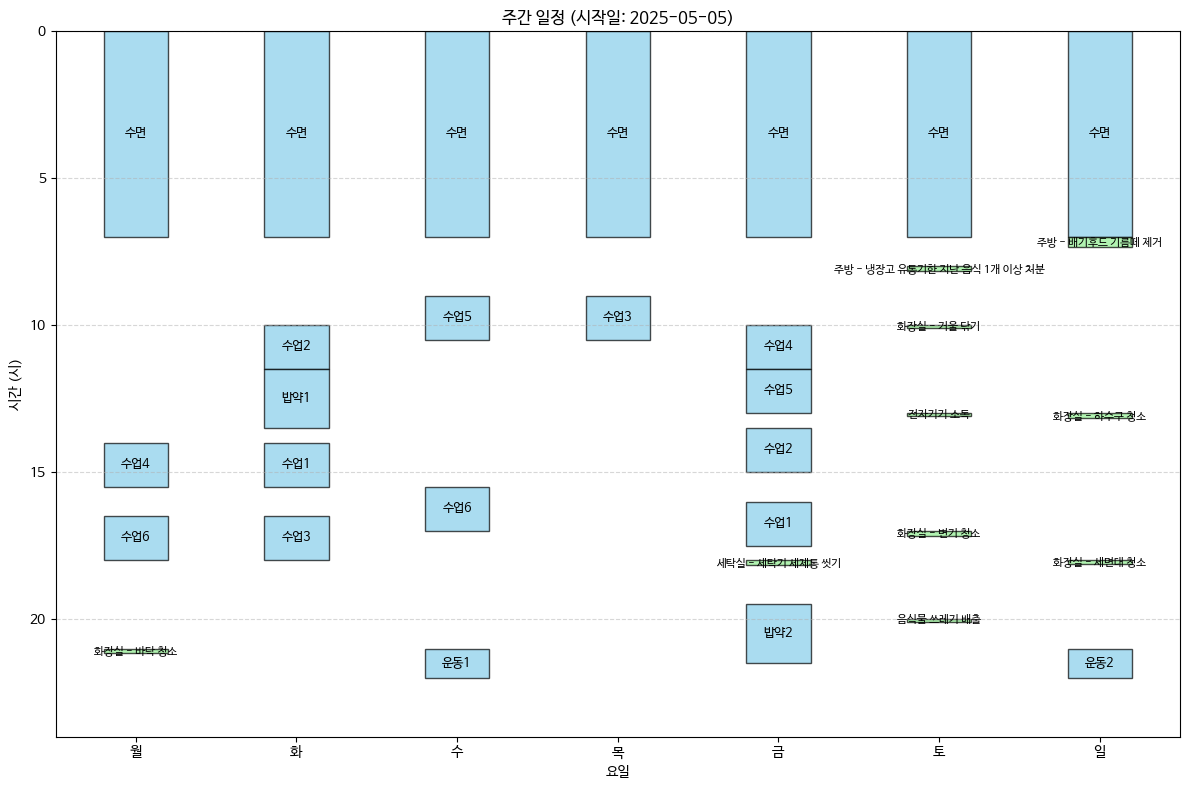

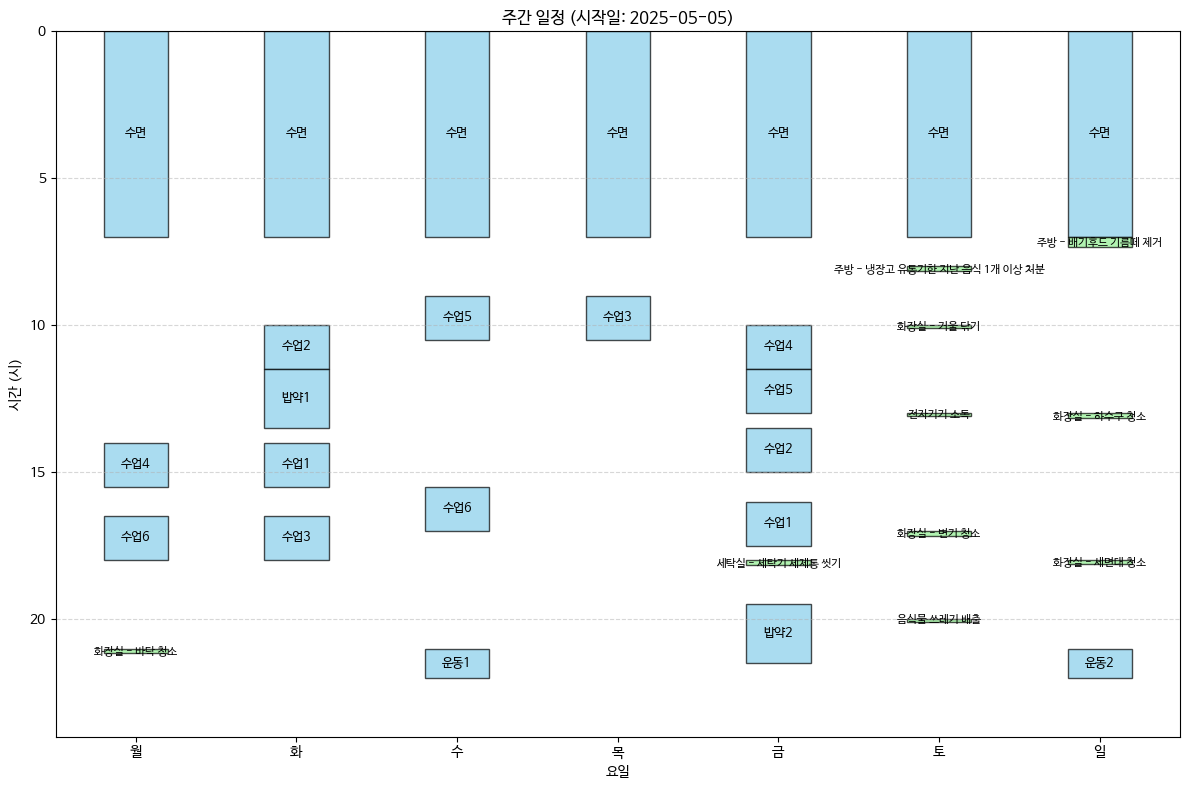

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 2 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


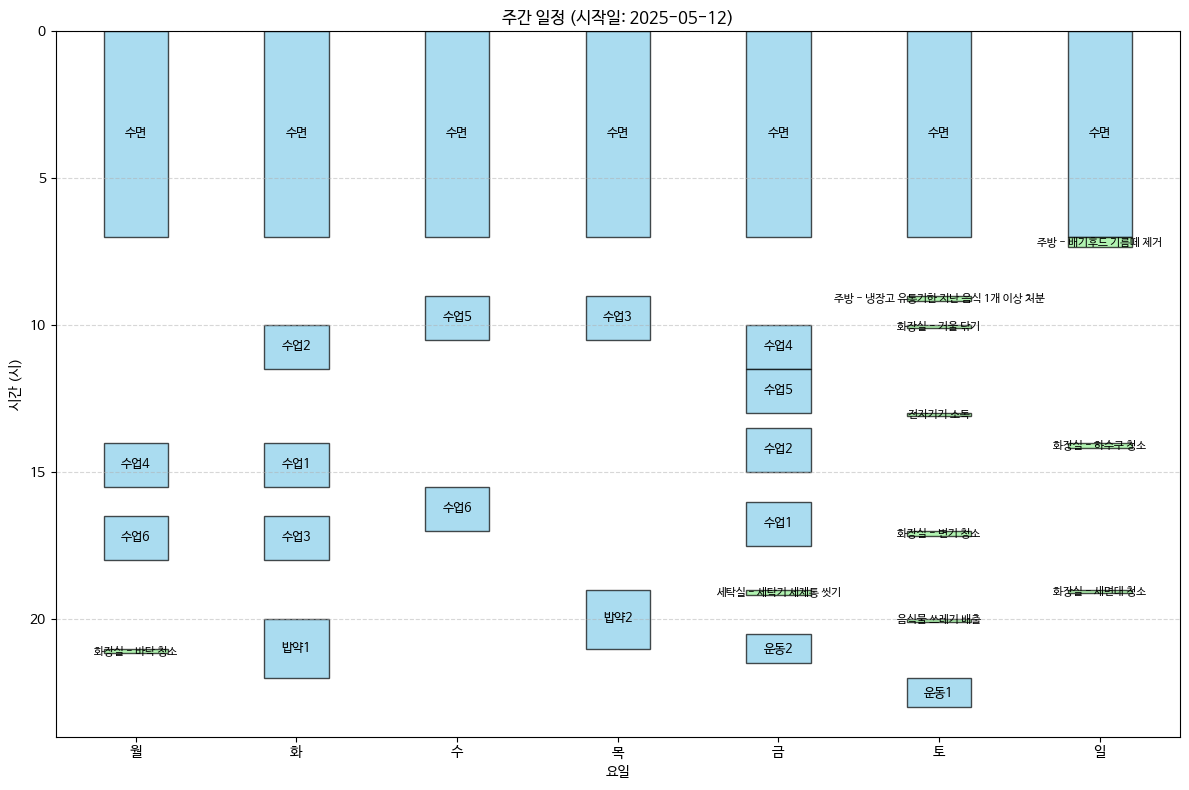

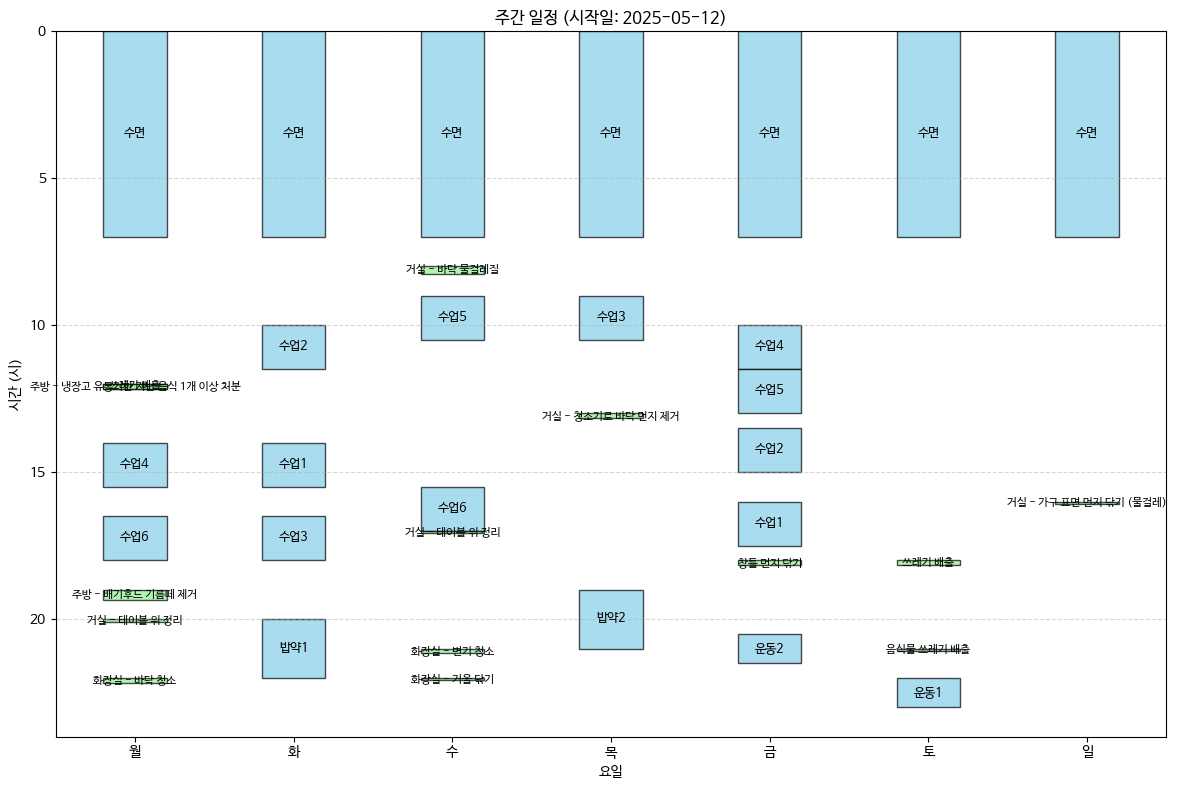

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 3 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


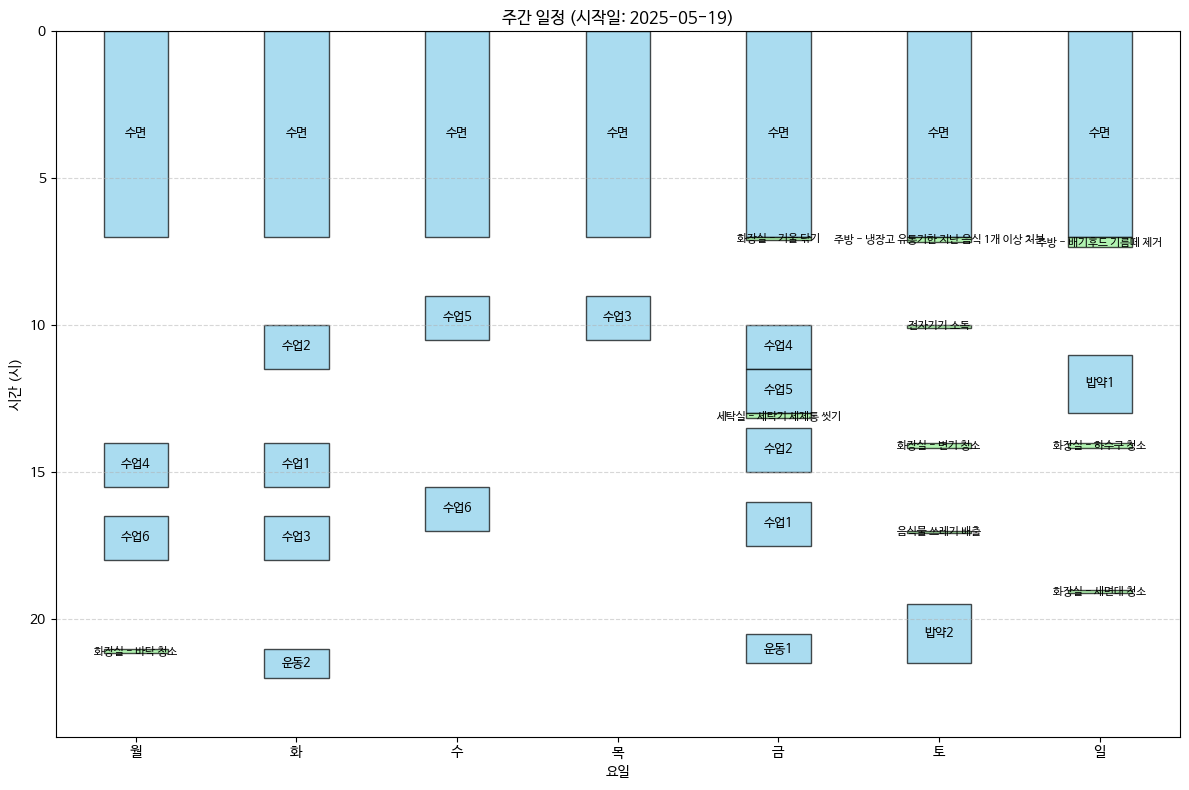

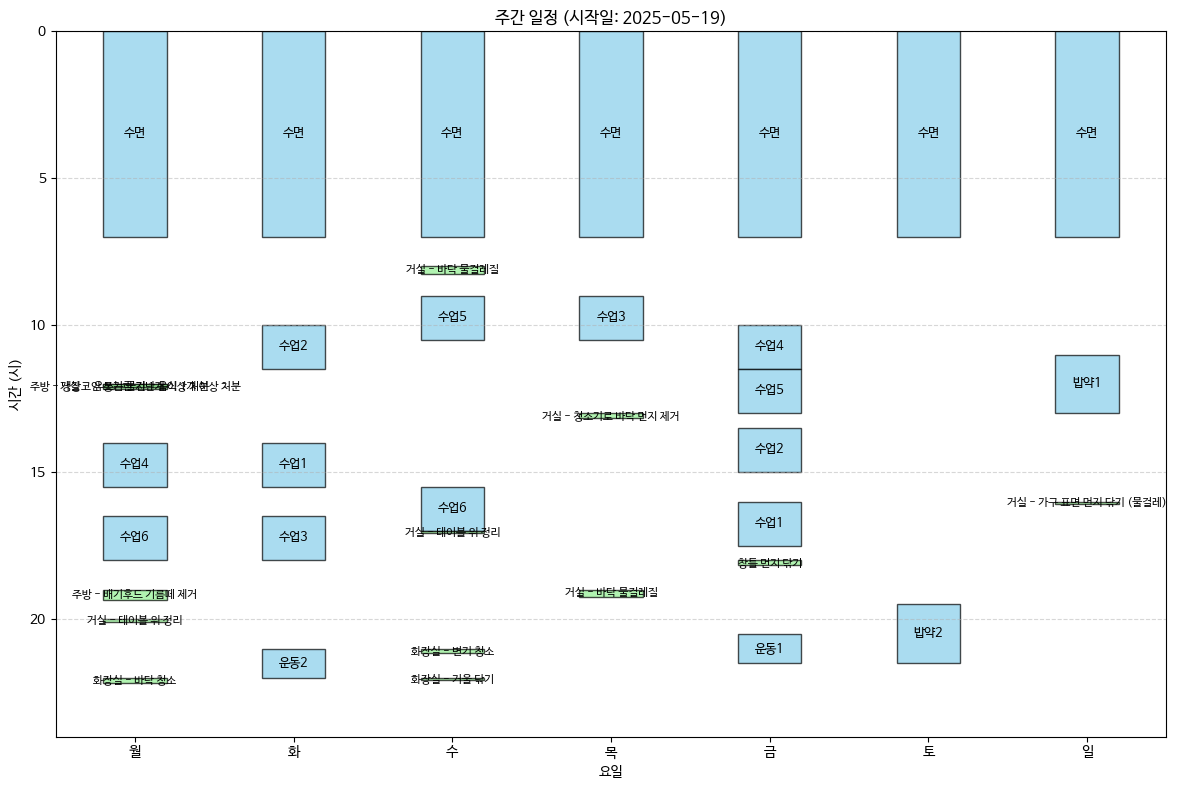

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 4 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


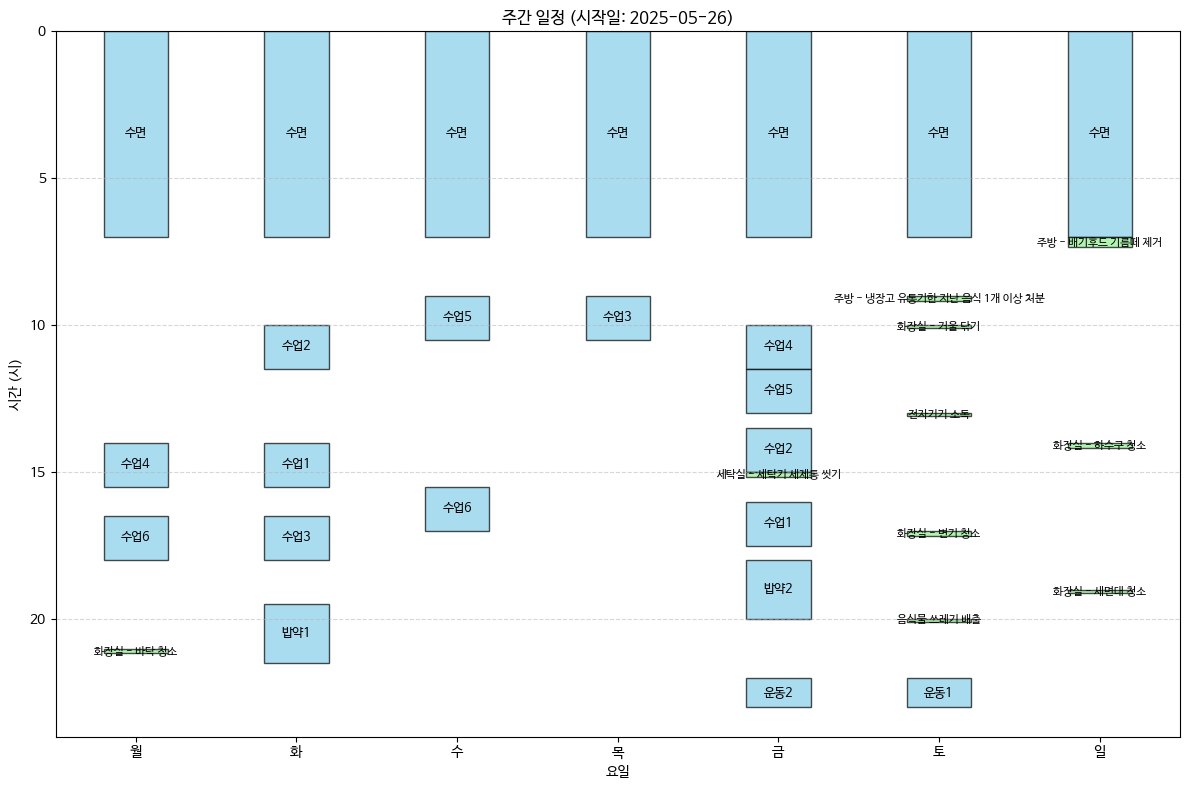

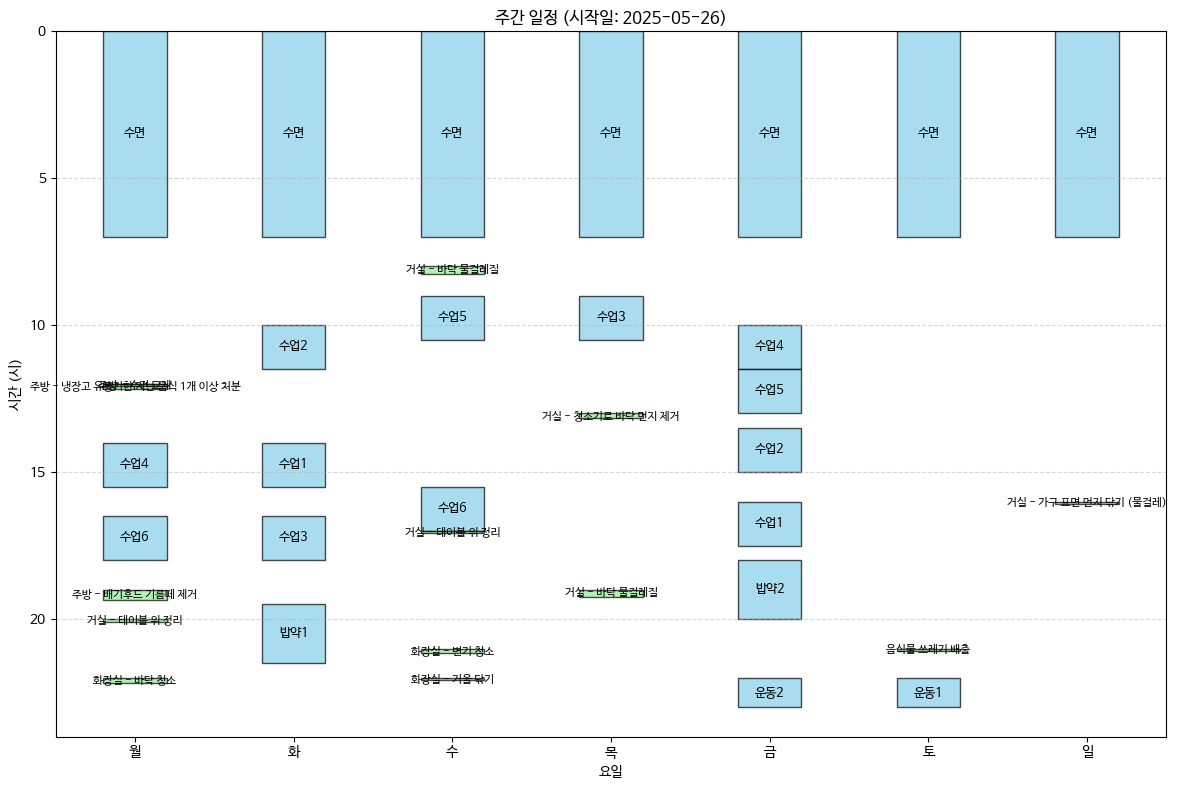

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 5 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


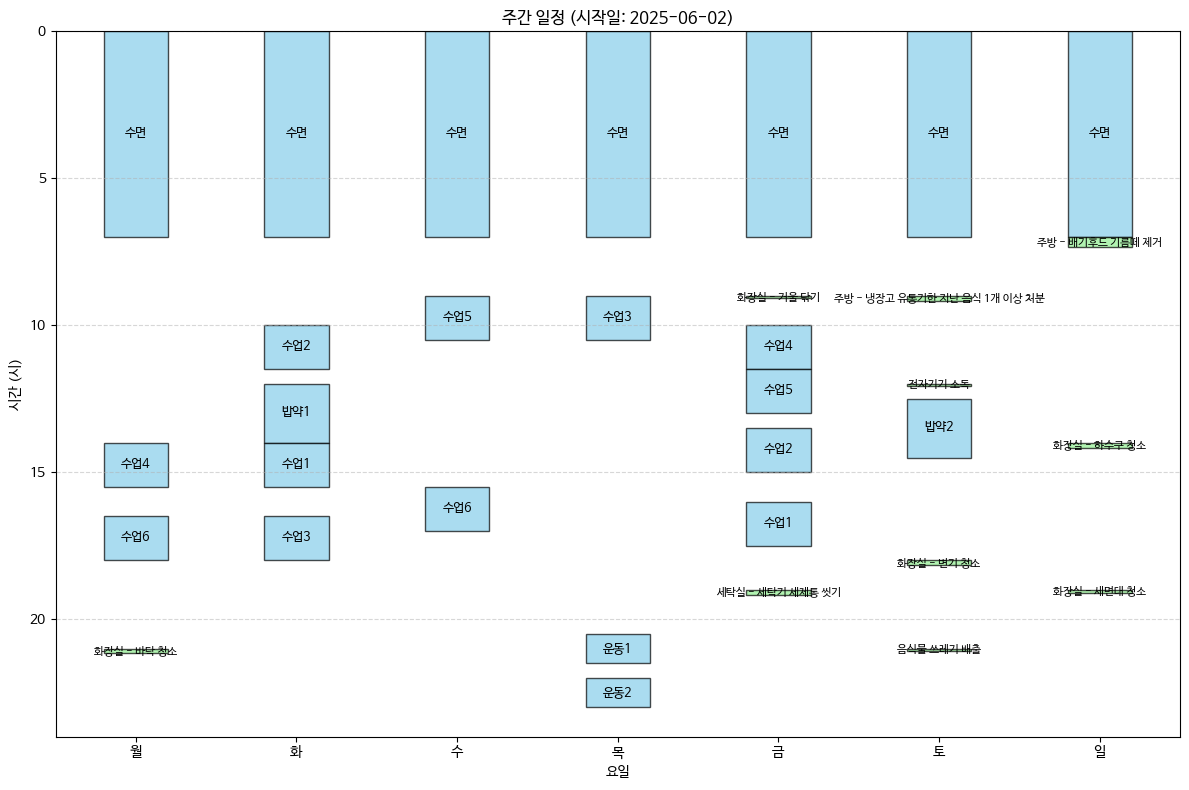

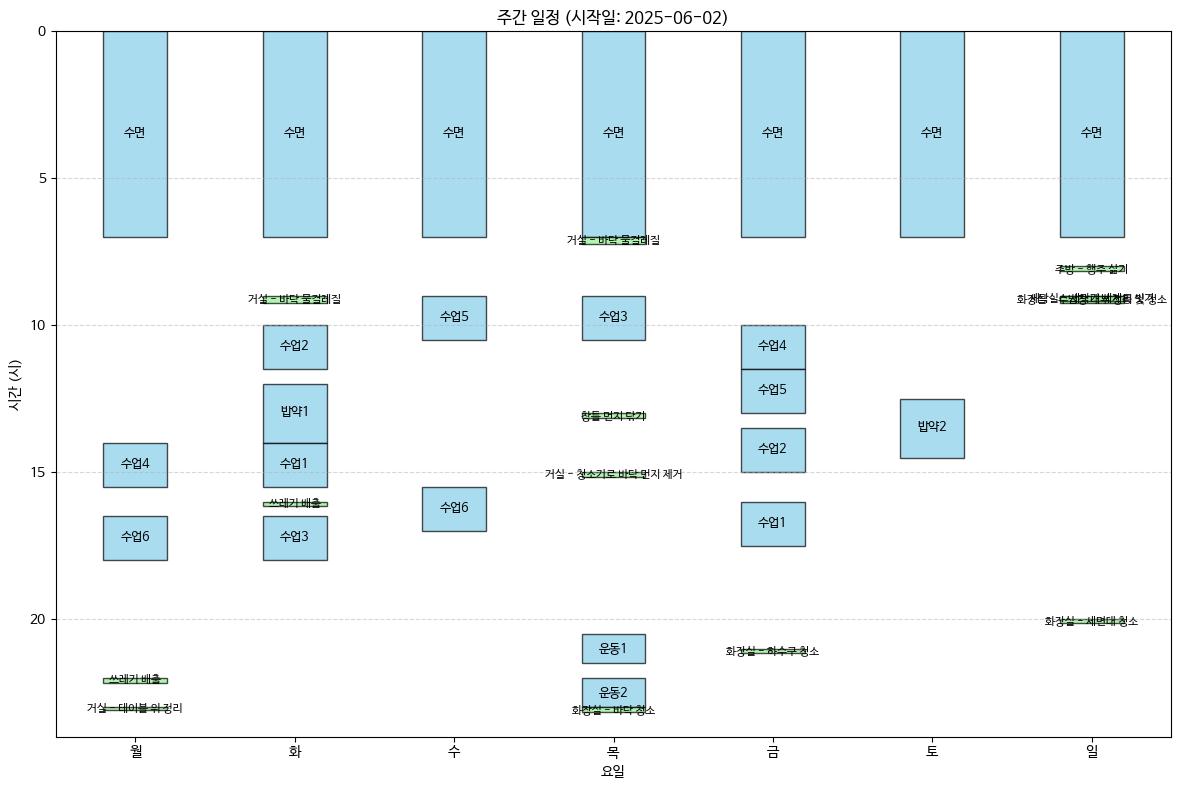

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 6 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


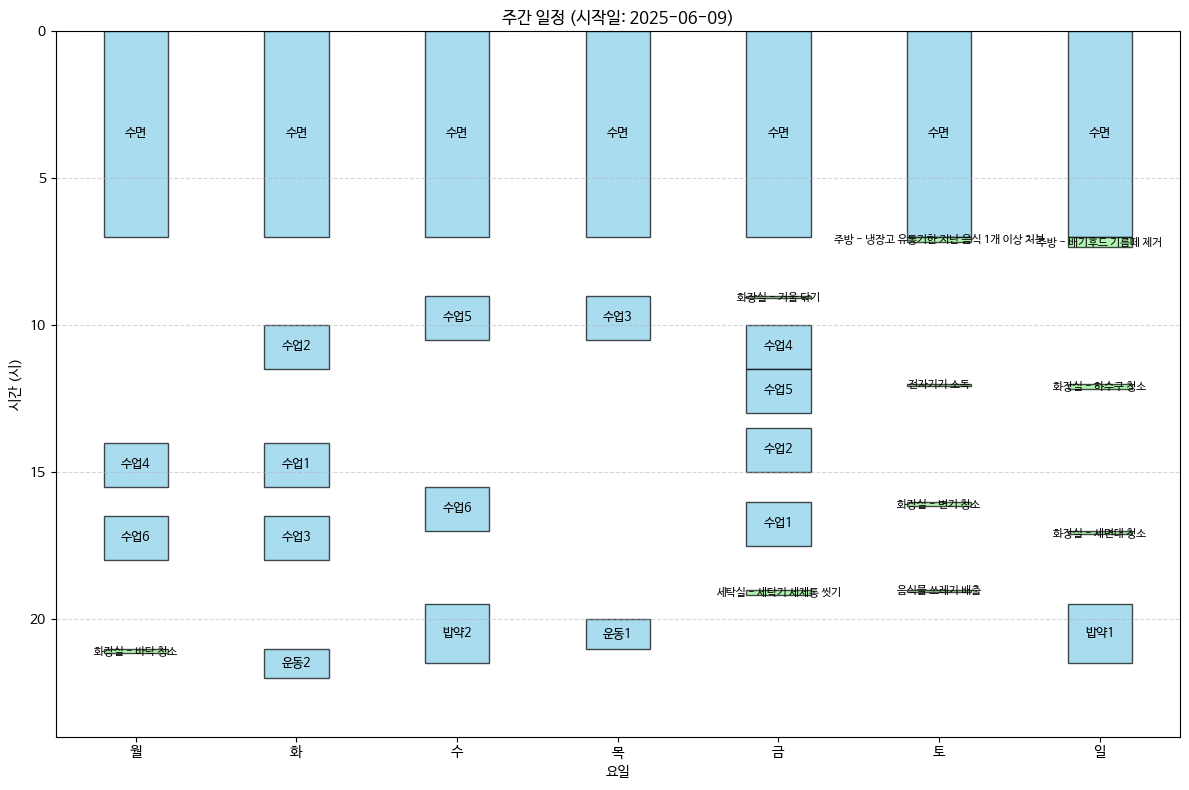

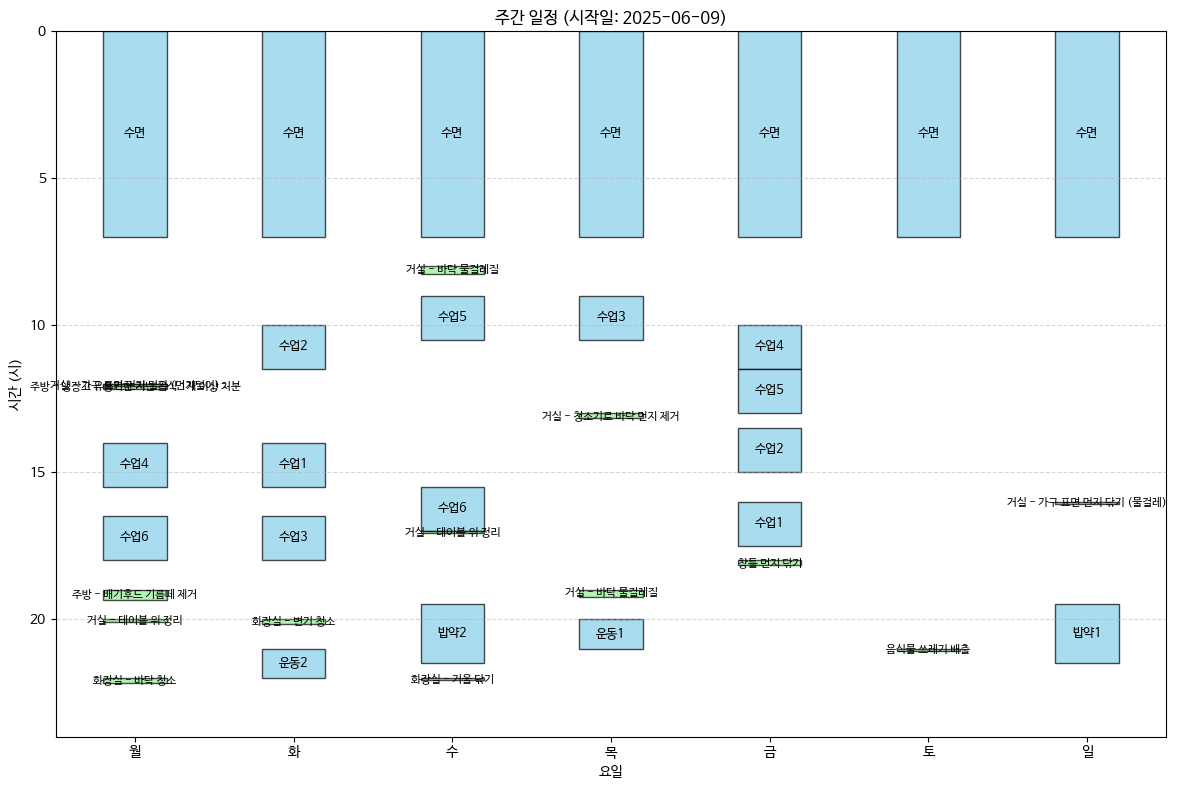

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 7 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


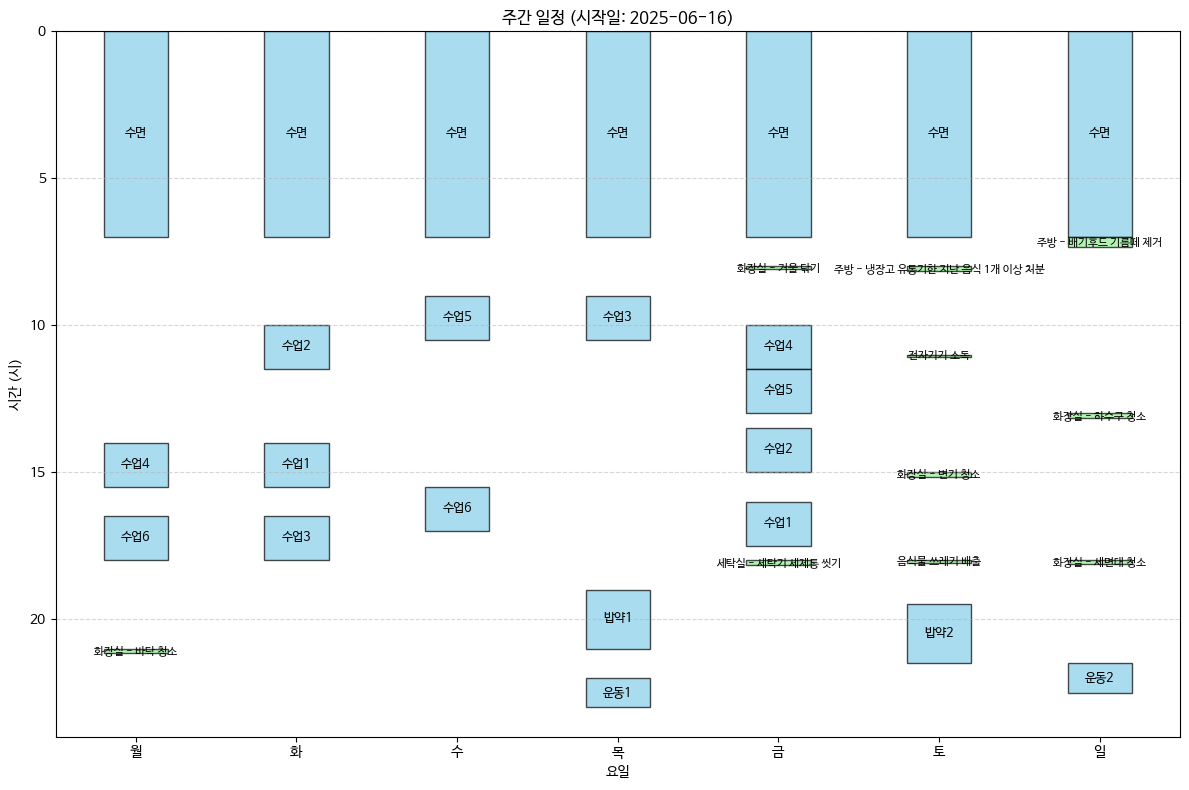

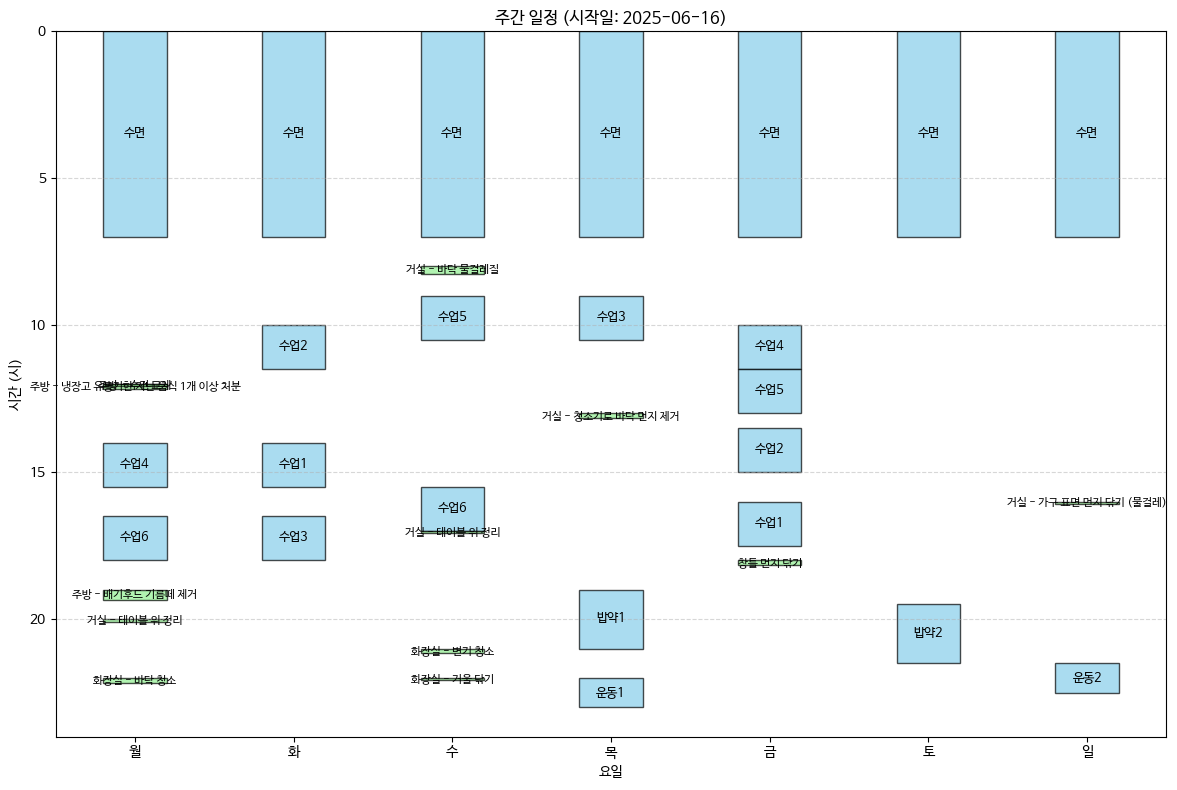

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 8 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


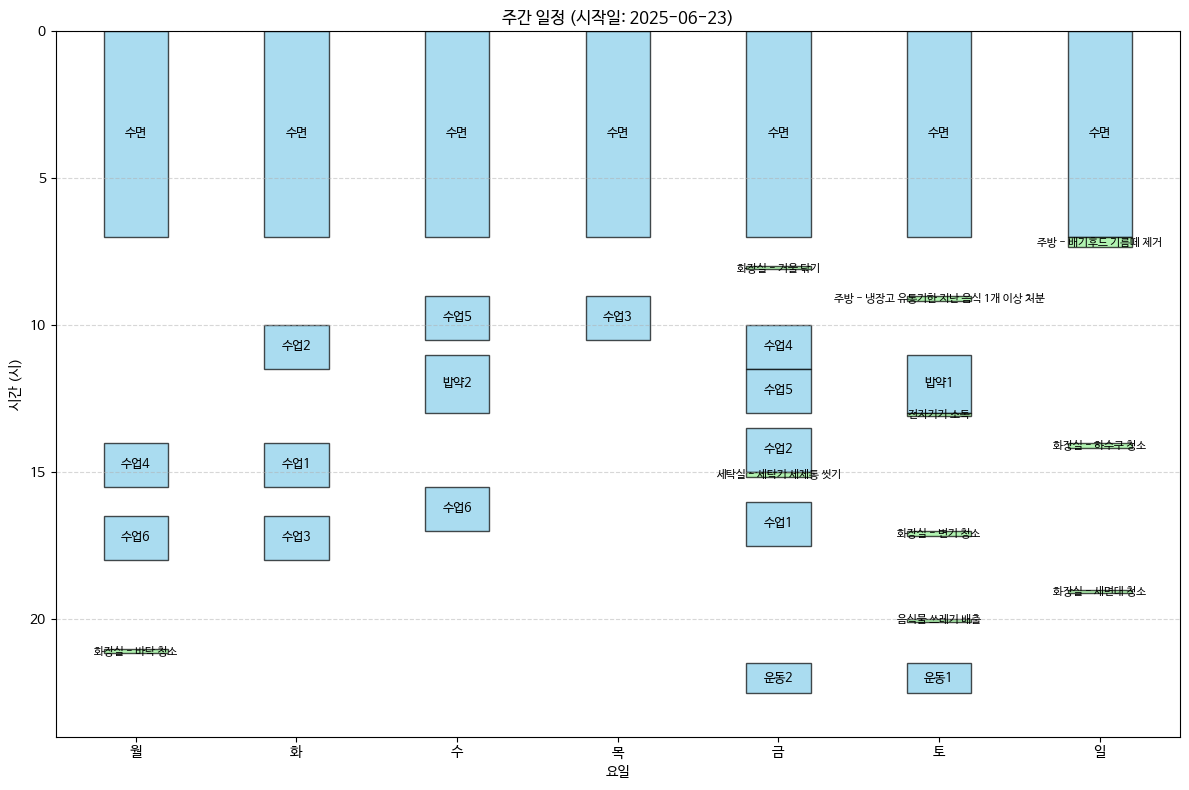

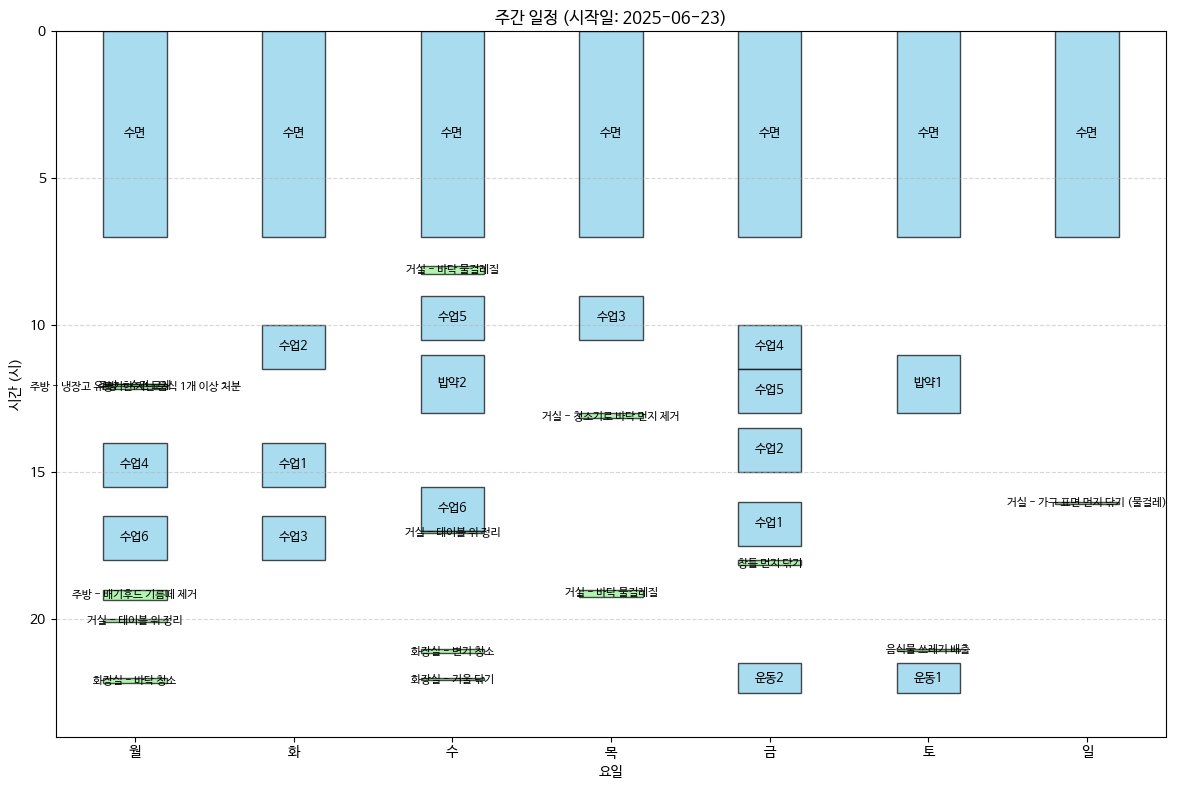

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 9 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


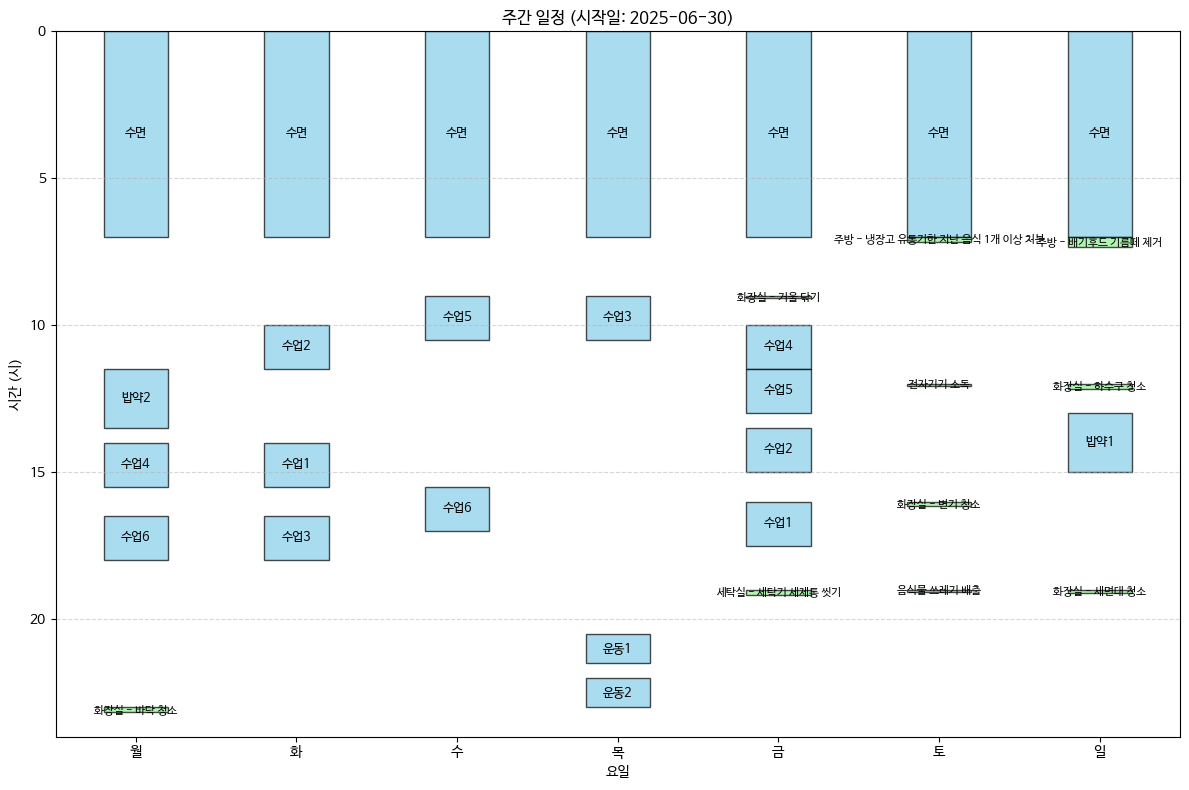

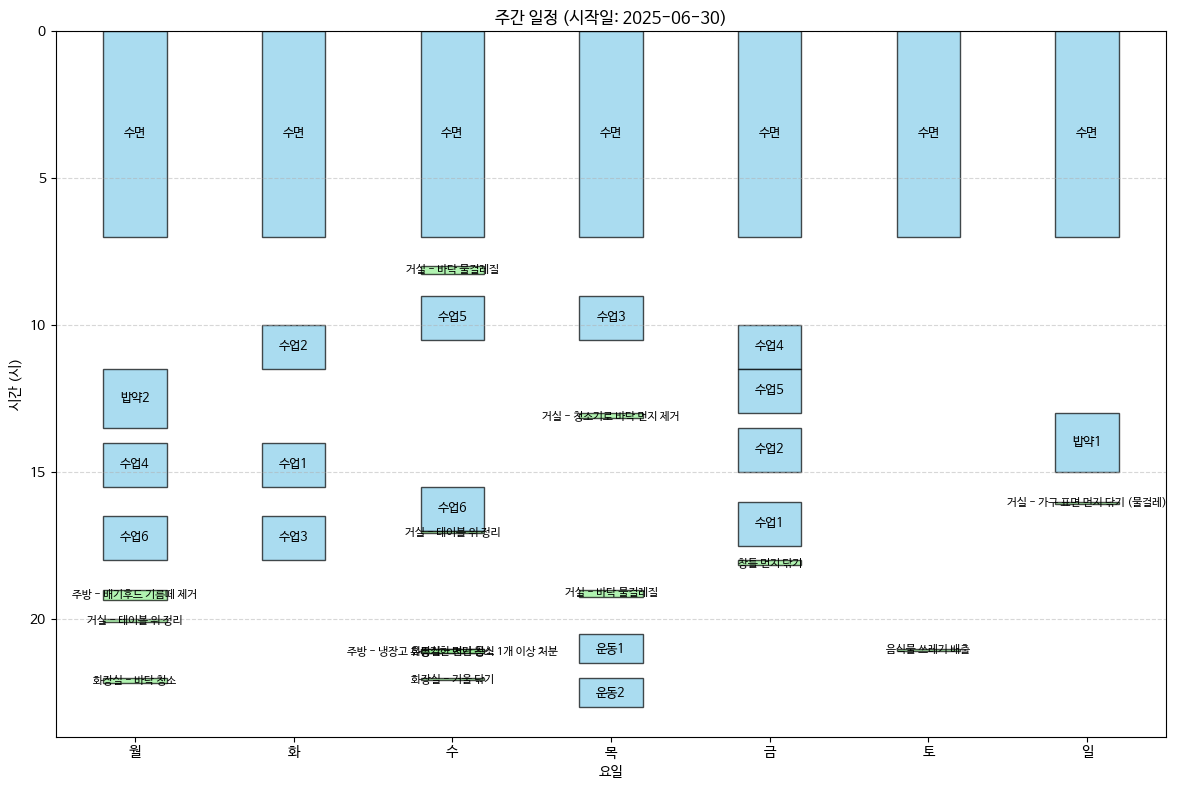

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 10 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


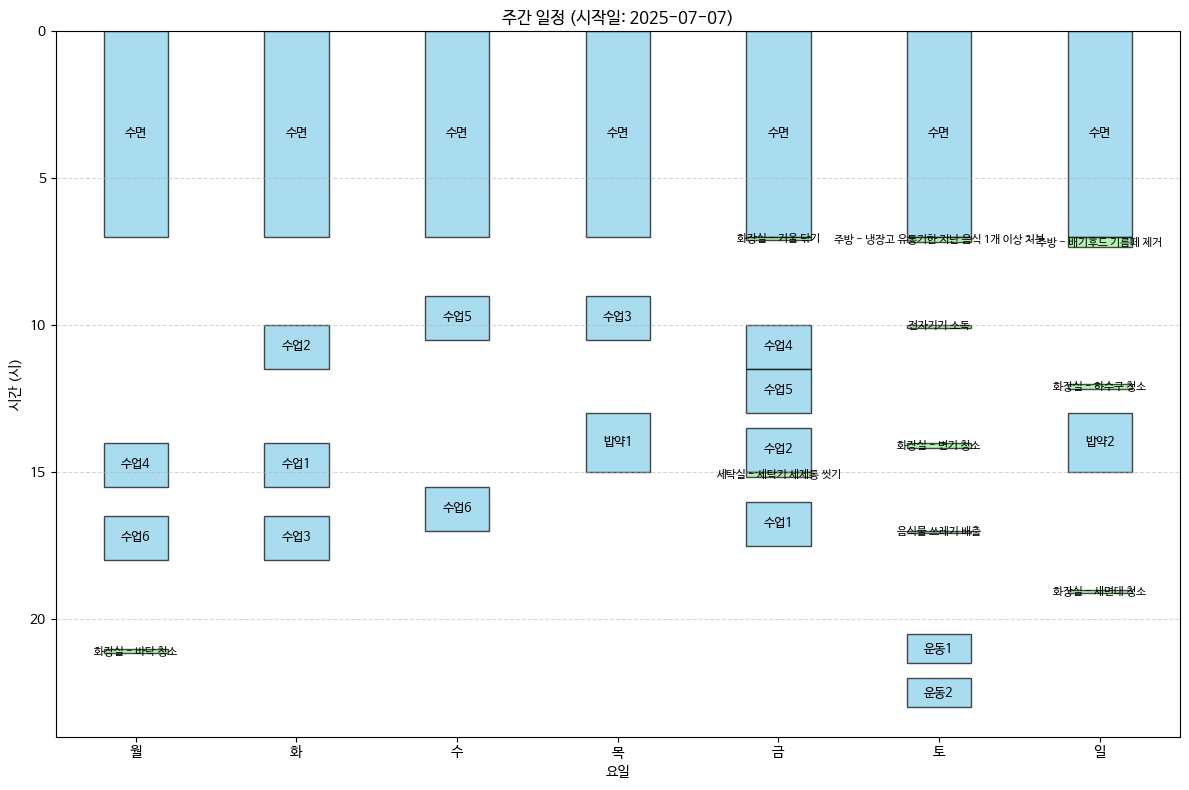

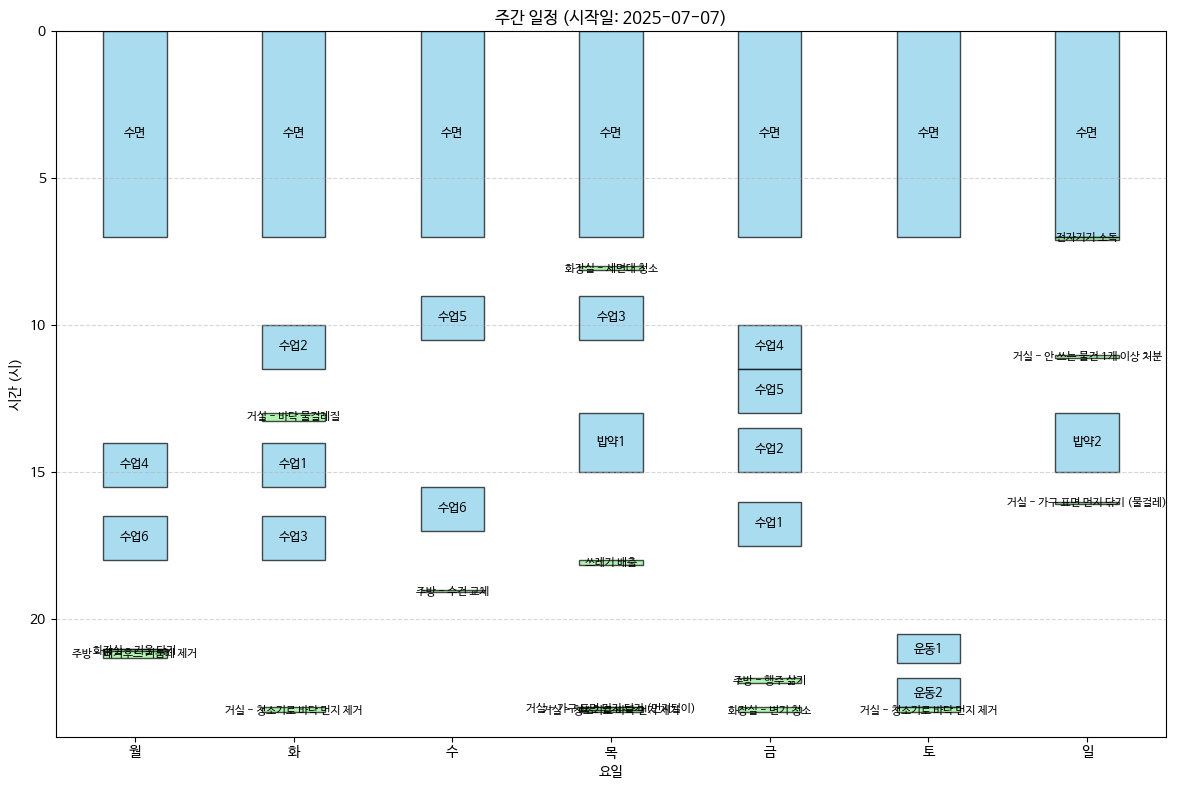

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [48]:
week_start = date(2025, 5, 5)

for i in range(WEEKS):
    print(f'--- {i + 1} ---')
    plot_weekly_schedule(fixed_schedules[i], initial_todos[i], week_start)
    plot_weekly_schedule(fixed_schedules[i], weekly_todos[i], week_start)
    week_start += timedelta(7)

## 내부 데이터 확인

In [49]:
# 마지막 수행일로부터 경과된 날짜 계산
w = 11
user_exec = build_user_execution_data(last_week_todo=weekly_todos[w-2],week=w-1, seed=SEED)
user_execution_data.update(user_exec)
prev_week_execution = prev_execution(user_execution_data, w)
compute_user_cleaning_status(prev_week_execution)  # 전역 user_cleaning_status 갱신

In [50]:
print('\n=== 마지막 수행일로부터 경과된 날짜 ===')
lst = [item for item in user_cleaning_status.items()]
print('\n'.join(map(str, lst)))


=== 마지막 수행일로부터 경과된 날짜 ===
('주방 - 수건 교체', {'last_done_days_ago': 5})
('주방 - 행주 삶기', {'last_done_days_ago': 3})
('주방 - 배기후드 기름떼 제거', {'last_done_days_ago': 7})
('주방 - 냉장고 유통기한 지난 음식 1개 이상 처분', {'last_done_days_ago': 12})
('세탁실 - 세탁기 세제통 씻기', {'last_done_days_ago': 36})
('화장실 - 바닥 청소', {'last_done_days_ago': 11})
('화장실 - 변기 청소', {'last_done_days_ago': 3})
('화장실 - 세면대 청소', {'last_done_days_ago': 4})
('화장실 - 하수구 청소', {'last_done_days_ago': 38})
('화장실 - 거울 닦기', {'last_done_days_ago': 5})
('화장실 - 수납장 내부 정리 및 청소', {'last_done_days_ago': 36})
('거실 - 가구 표면 먼지 닦기 (물걸레)', {'last_done_days_ago': 1})
('거실 - 가구 표면 먼지 털기 (먼지털이)', {'last_done_days_ago': 4})
('거실 - 바닥 물걸레질', {'last_done_days_ago': 4})
('거실 - 청소기로 바닥 먼지 제거', {'last_done_days_ago': 2})
('거실 - 테이블 위 정리', {'last_done_days_ago': 12})
('거실 - 안 쓰는 물건 1개 이상 처분', {'last_done_days_ago': 1})
('창틀 먼지 닦기', {'last_done_days_ago': 10})
('전자기기 소독', {'last_done_days_ago': 1})
('쓰레기 배출', {'last_done_days_ago': 4})
('음식물 쓰레기 배출', {'last_done_days_ago': 9

In [51]:
print('\n=== 청소 목록 ===')
print('\n'.join(map(str, cleaning_tasks)))


=== 청소 목록 ===
{'주방 - 수건 교체': {'duration': 0.08333333333333333, 'interval': 5, 'description': '깨끗한 수건으로 교체 후 사용한 수건은 세탁 바구니에 넣기'}}
{'주방 - 행주 삶기': {'duration': 0.16666666666666666, 'interval': 7, 'description': '행주를 삶거나 세탁기에 고온세탁하여 위생 관리'}}
{'주방 - 배기후드 기름떼 제거': {'duration': 0.3333333333333333, 'interval': 30, 'description': '기름 제거제를 뿌리고 문질러 닦은 후 물로 헹구기'}}
{'주방 - 냉장고 유통기한 지난 음식 1개 이상 처분': {'duration': 0.16666666666666666, 'interval': 7, 'description': '유통기한 지난 식품 확인 후 폐기'}}
{'세탁실 - 세탁기 세제통 씻기': {'duration': 0.16666666666666666, 'interval': 30, 'description': '세제 찌꺼기를 제거하고 물로 헹군 후 건조'}}
{'화장실 - 바닥 청소': {'duration': 0.16666666666666666, 'interval': 14, 'description': '바닥에 락스를 뿌리고 청소솔과 세제로 구석구석 닦기'}}
{'화장실 - 변기 청소': {'duration': 0.16666666666666666, 'interval': 7, 'description': '변기 전용 세제로 내부와 테두리 문지르기'}}
{'화장실 - 세면대 청소': {'duration': 0.11666666666666667, 'interval': 5, 'description': '물때와 치약 자국 등을 세정제로 제거'}}
{'화장실 - 하수구 청소': {'duration': 0.16666666666666666, 'interval': 7, 'description': '